# Homework 4: Pairs Trading of NVDA
---
**學號：** M11218014  
**姓名：** 王士誠

## 作業目標
---
In the recent case, we used Affinity Propagation（親和力傳播聚類）to find that AXON is a candidate to pair with NVDA.  

Use the same dataset, modify the sample code, and try applying the K-means（K-means 聚類分析）or Hierarchical Clustering（階層聚類分析）model to find more candidates.

## 目錄
---
1. [程式庫載入與資料準備](#1-程式庫載入與資料準備)
2. [探索性資料分析](#2-探索性資料分析)
3. [資料前處理](#3-資料前處理)
4. [K-Means 聚類分析](#4-k-means-聚類分析)
5. [階層聚類分析](#5-階層聚類分析)
6. [親和力傳播聚類](#6-親和力傳播聚類)
7. [聚類效果評估](#7-聚類效果評估)
8. [配對選擇與共整合檢驗](#8-配對選擇與共整合檢驗)
9. [NVDA 專項分析](#9-nvda-專項分析)
10. [視覺化結果](#10-視覺化結果)
---

## 1. 程式庫載入與資料準備
---
### 1.1 載入套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn import metrics, cluster
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from itertools import cycle
from statsmodels.tsa.stattools import coint
import warnings

In [3]:
# 關閉警告訊息
warnings.filterwarnings('ignore')

### 1.2 資料載入

In [4]:
# 匯入已從 Yahoo Finance 獲得的數據
dataset = read_csv('SP500Data.csv', index_col=0)
print("Dataset type:", type(dataset))

Dataset type: <class 'pandas.core.frame.DataFrame'>


## 2. 探索性資料分析
---
### 2.1 資料基本資訊

In [5]:
# 數據形狀
print("Dataset shape:", dataset.shape)

# 查看數據
set_option('display.width', 100)
print("Dataset head:")
print(dataset.head(5))

# 描述數據
set_option('display.precision', 3)
print("Dataset description:")
print(dataset.describe())

Dataset shape: (1768, 502)
Dataset head:
                  AOS        ABT       ABBV         ACN        ADBE    AMD       AES        AFL  \
Date                                                                                              
2018-01-02  54.426796  52.048283  72.345779  138.659592  177.699997  10.98  8.634363  37.271656   
2018-01-03  54.754086  52.163368  73.477905  139.299545  181.039993  11.55  8.626429  37.381805   
2018-01-04  55.010605  52.074833  73.058868  140.949005  183.220001  12.12  8.594687  37.767361   
2018-01-05  55.718266  52.225346  74.330681  142.111664  185.339996  11.88  8.626429  38.017338   
2018-01-08  55.983631  52.074833  73.139732  143.247375  185.039993  12.28  8.626429  38.114788   

                    A         APD  ...        WMB         WTW        WDAY        WYNN        XEL  \
Date                               ...                                                             
2018-01-02  64.180237  139.873764  ...  20.753773  133.155411  10

### 2.2 資料品質檢查

In [6]:
# 檢查是否有空值並移除空值
print('Null values =', dataset.isnull().values.any())

# 移除超過 30% 缺失值的欄位
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
print("Missing fractions head:")
print(missing_fractions.head(10))

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
dataset.drop(labels=drop_list, axis=1, inplace=True)
print("Dataset shape after dropping columns:", dataset.shape)

Null values = True
Missing fractions head:
BF.B     1.000
BRK.B    1.000
SW       0.926
GEV      0.888
SOLV     0.888
VLTO     0.819
KVUE     0.760
GEHC     0.706
CEG      0.576
ABNB     0.419
dtype: float64
Dataset shape after dropping columns: (1768, 489)


## 3. 資料前處理
---
### 3.1 缺失值處理

In [7]:
# 用數據集中最後一個可用值填充缺失值
dataset = dataset.fillna(method='ffill')
print("Dataset head after filling:")
print(dataset.head(2))

Dataset head after filling:
               AOS     ABT    ABBV     ACN    ADBE    AMD    AES     AFL       A      APD  ...  \
Date                                                                                       ...   
2018-01-02  54.427  52.048  72.346  138.66  177.70  10.98  8.634  37.272  64.180  139.874  ...   
2018-01-03  54.754  52.163  73.478  139.30  181.04  11.55  8.626  37.382  65.813  140.634  ...   

               WMB      WTW    WDAY     WYNN     XEL     XYL     YUM    ZBRA      ZBH     ZTS  
Date                                                                                           
2018-01-02  20.754  133.155  103.40  151.863  38.650  62.595  71.868  103.71  114.007  68.287  
2018-01-03  21.327  135.647  105.17  150.218  38.392  63.358  71.806  105.77  114.797  68.601  

[2 rows x 489 columns]


### 3.2 特徵工程

- 為了聚類的目的，我們將使用年化報酬率和變異數作為變數，因為它們是股票表現和波動性的指標。

In [8]:
# 計算理論一年期間的平均年化百分比報酬率和波動率
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data = returns

### 3.3 資料標準化

- 在應用聚類之前，所有變數都應該在相同的尺度上，否則具有大值的特徵將主導結果。

In [9]:
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# 總結轉換後的數據
print("Rescaled dataset head:")
print(rescaledDataset.head(2))
X = rescaledDataset
print("X head:")
print(X.head(2))

Rescaled dataset head:
     Returns  Volatility
AOS   -0.824      -0.519
ABT   -0.184      -0.986
X head:
     Returns  Volatility
AOS   -0.824      -0.519
ABT   -0.184      -0.986


## 4. K-Means 聚類分析（K-Means Clustering）
---
### 4.1 最佳聚類數量確定

#### 4.1.1 肘部法則（Elbow Method）
- 計算不同聚類數量下的總平方誤差和（SSE）

- 尋找 SSE 下降趨緩的「肘部」點，該點通常為最佳聚類數量

In [10]:
distorsions = []
max_loop = 20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

  File "c:\Users\de837\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\de837\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\de837\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

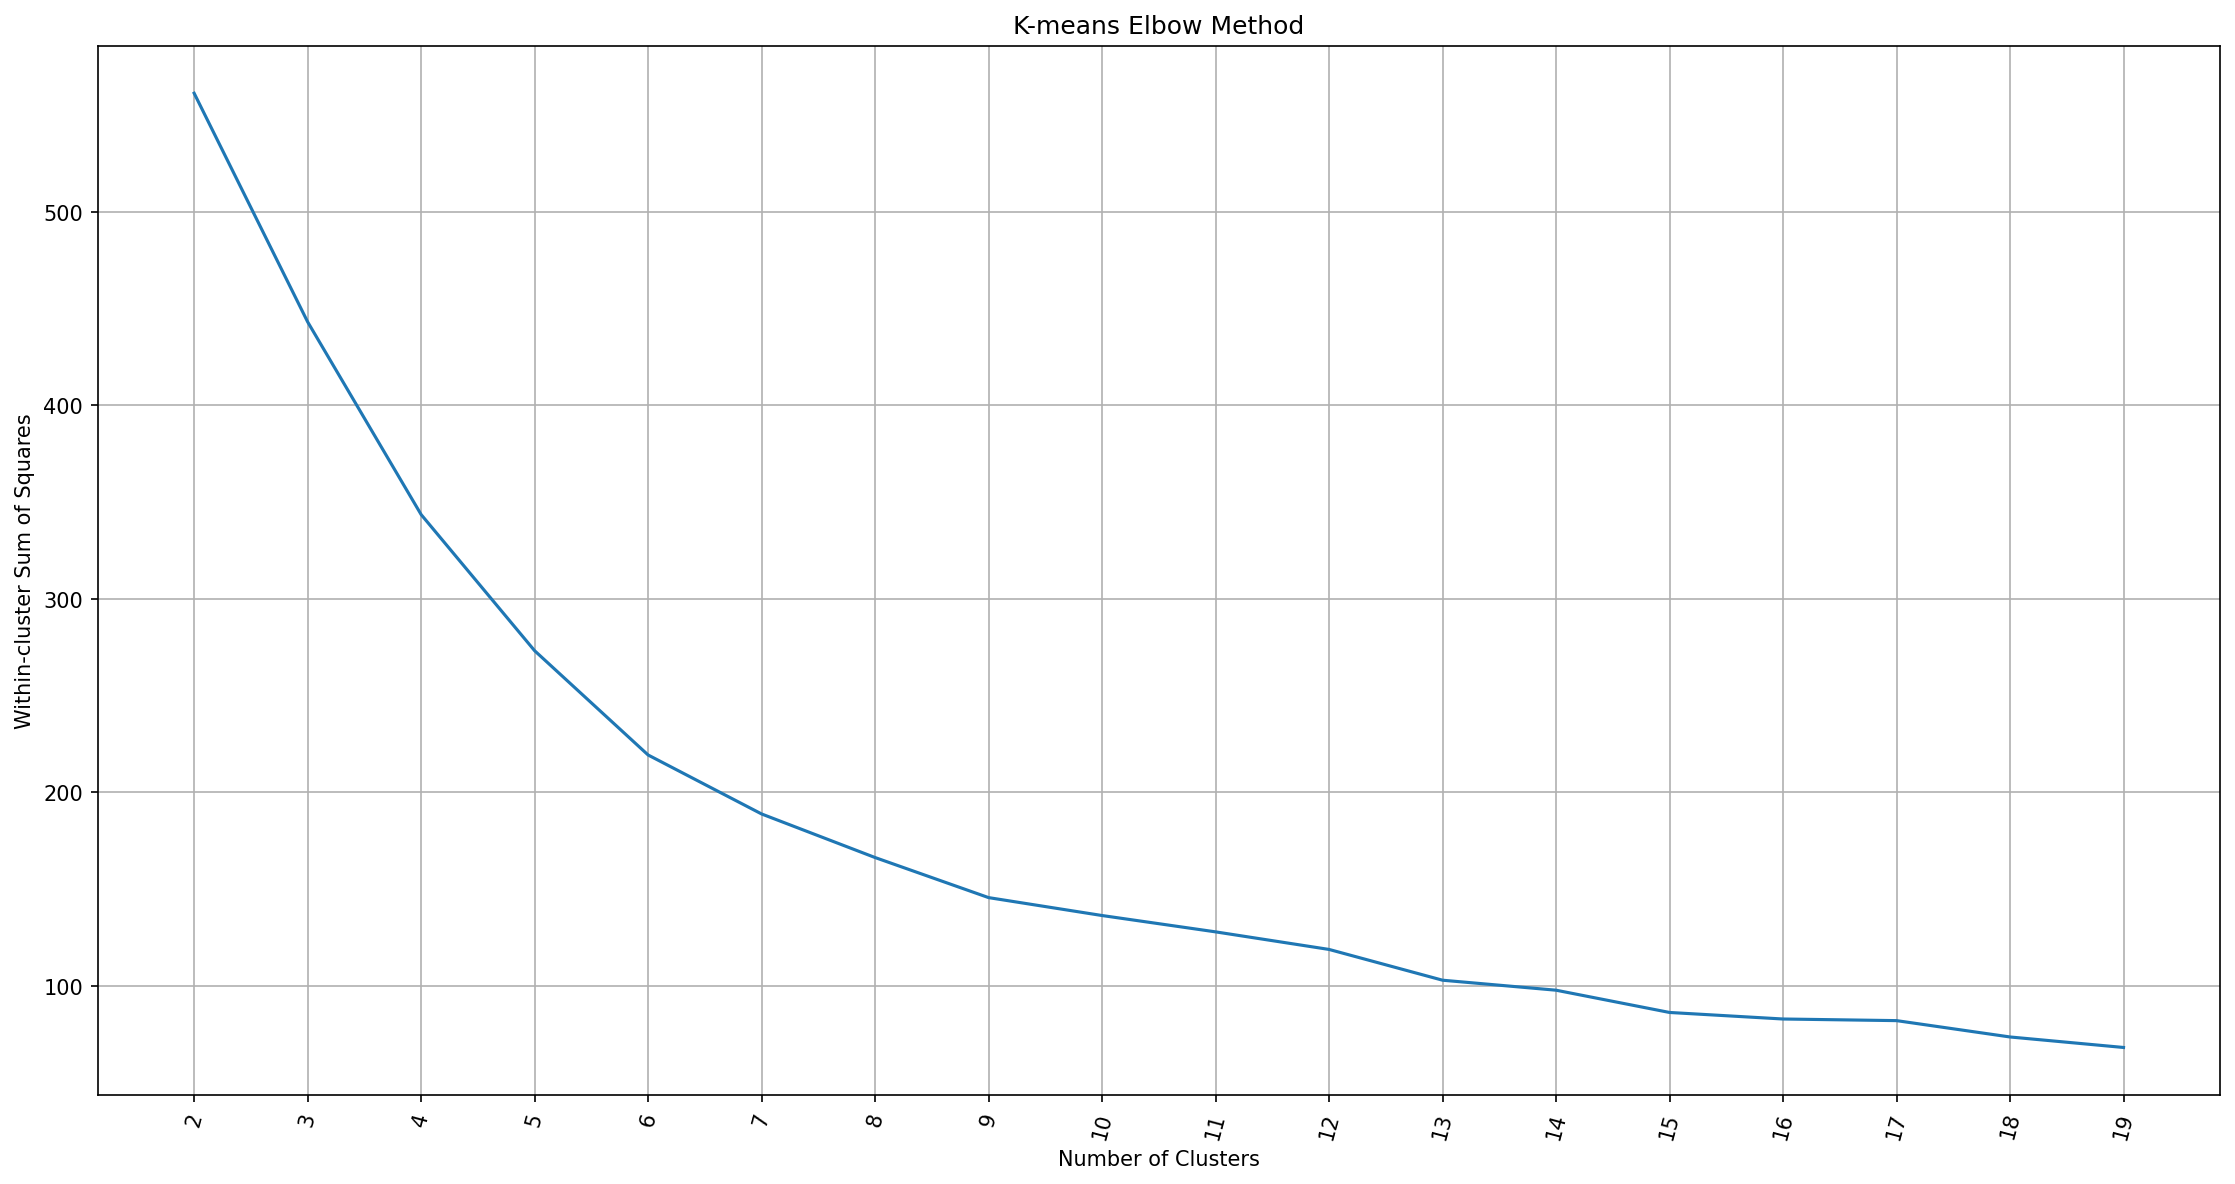

In [11]:
fig = plt.figure(figsize=(15, 8), dpi=150)
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)
plt.title('K-means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.tight_layout()
plt.show()

觀察上圖，似乎在 5 或 6 個聚類時出現肘部「轉折」，我們可以看到當聚類數量超過 6 時，聚類內平方誤差和趨於平穩。

#### 4.1.2 輪廓分析（Silhouette Analysis）

- 評估聚類品質的指標

- 分數越高表示聚類效果越好

- 結合肘部法則確定最佳聚類數

In [12]:
# 輪廓分數
silhouette_score = []
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
    kmeans.fit(X)
    silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))

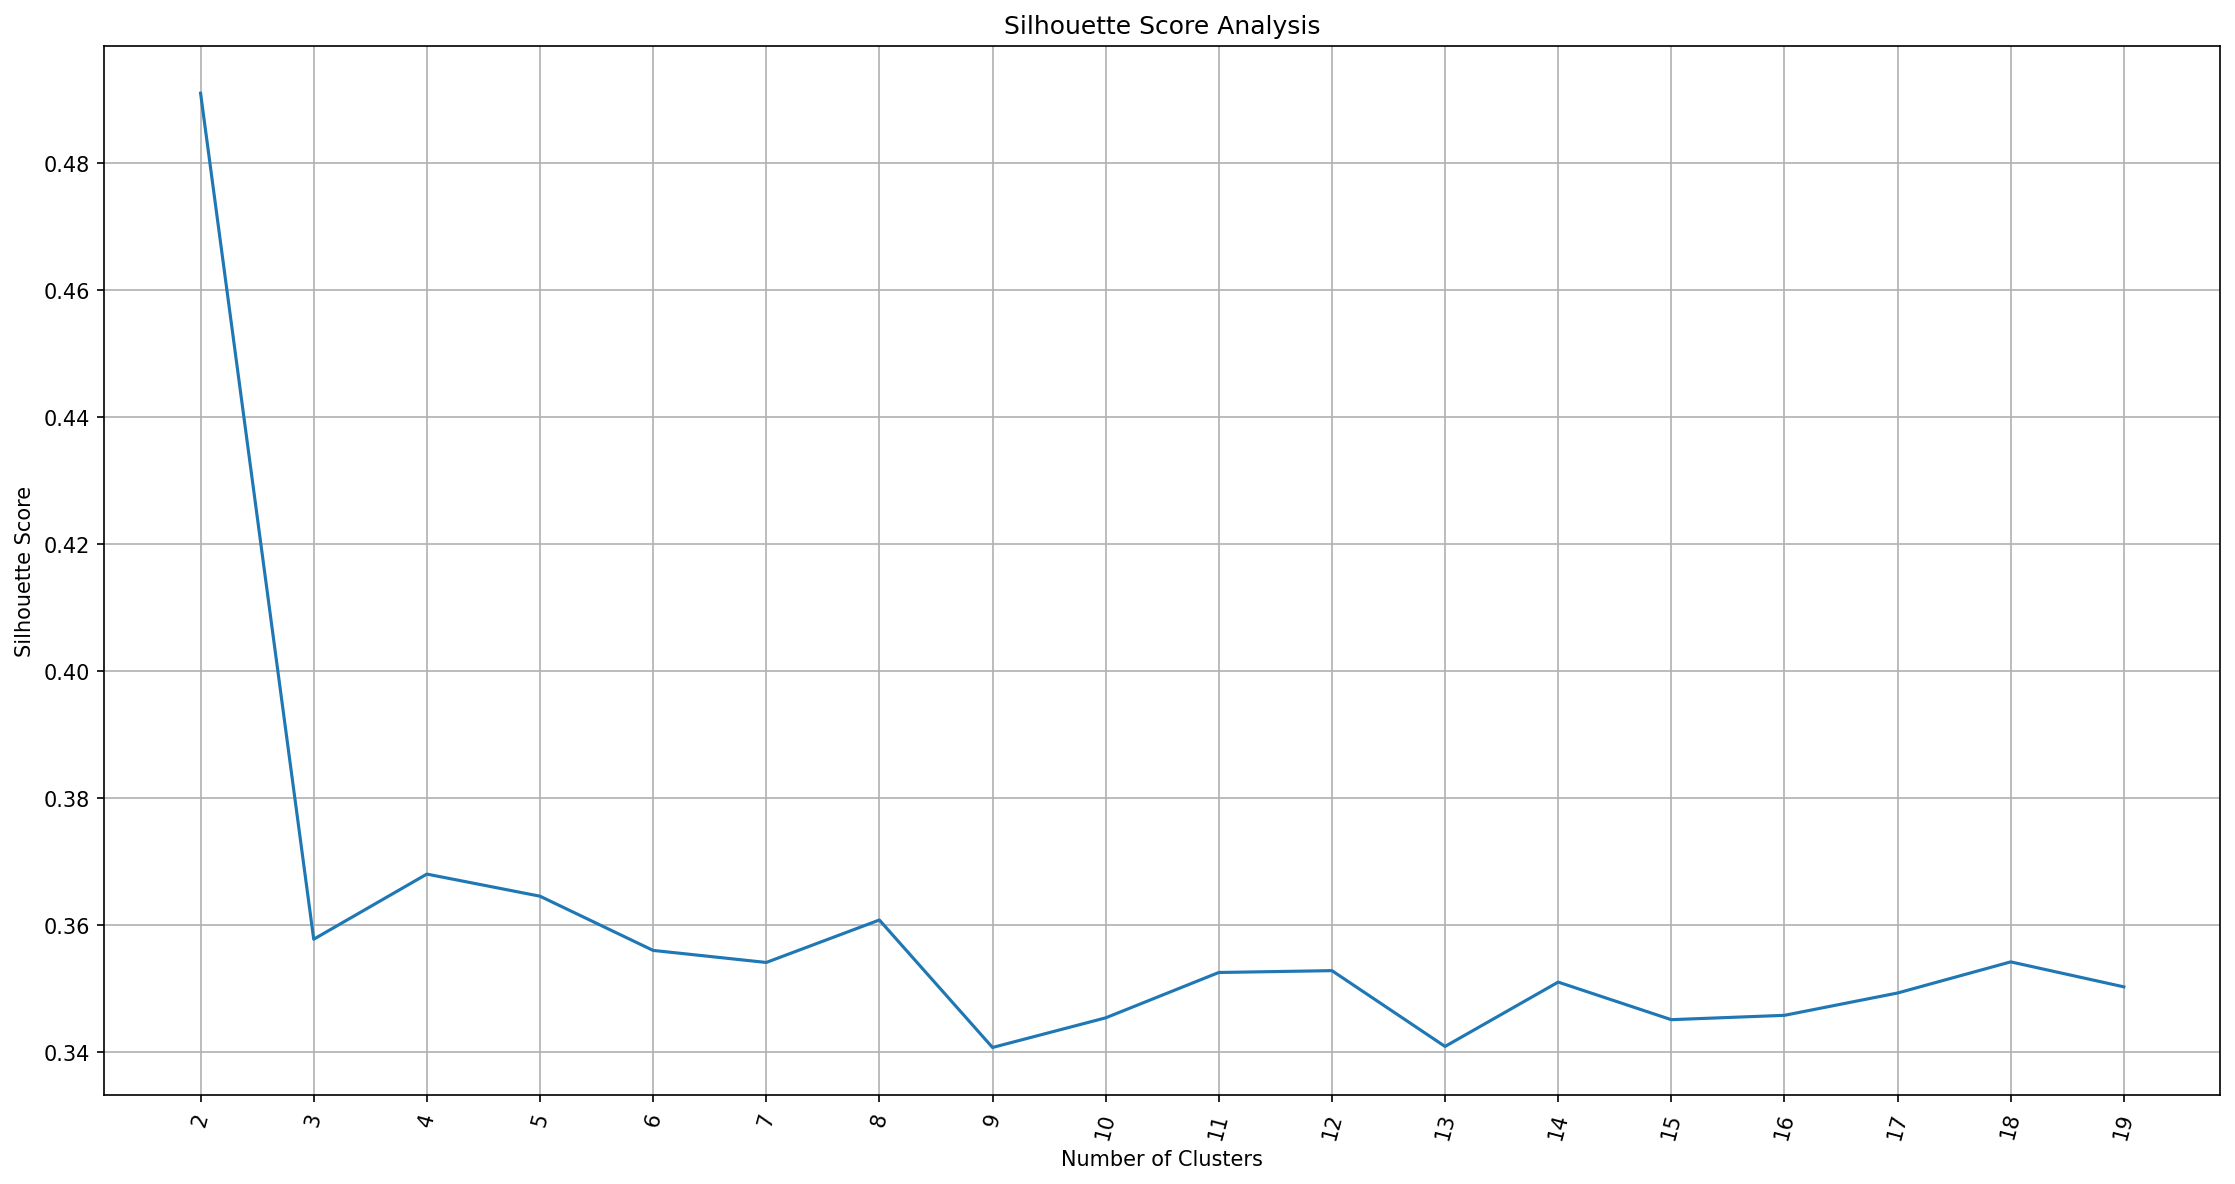

In [13]:
fig = plt.figure(figsize=(15, 8), dpi=150)
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)
plt.title('Silhouette Score Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

- 從輪廓分數圖表中，我們可以看到圖表的各個部分都可以看到轉折。

- 由於 6 個聚類後 SSE 沒有太大差異，我們在 K-means 模型中偏好 6 個聚類。

### 4.2 K-Means 聚類執行

In [14]:
# 建立具有六個聚類的 K-means 模型並視覺化結果。
nclust = 6

# 使用 K-means 擬合
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

# 提取標籤
target_labels = k_means.predict(X)

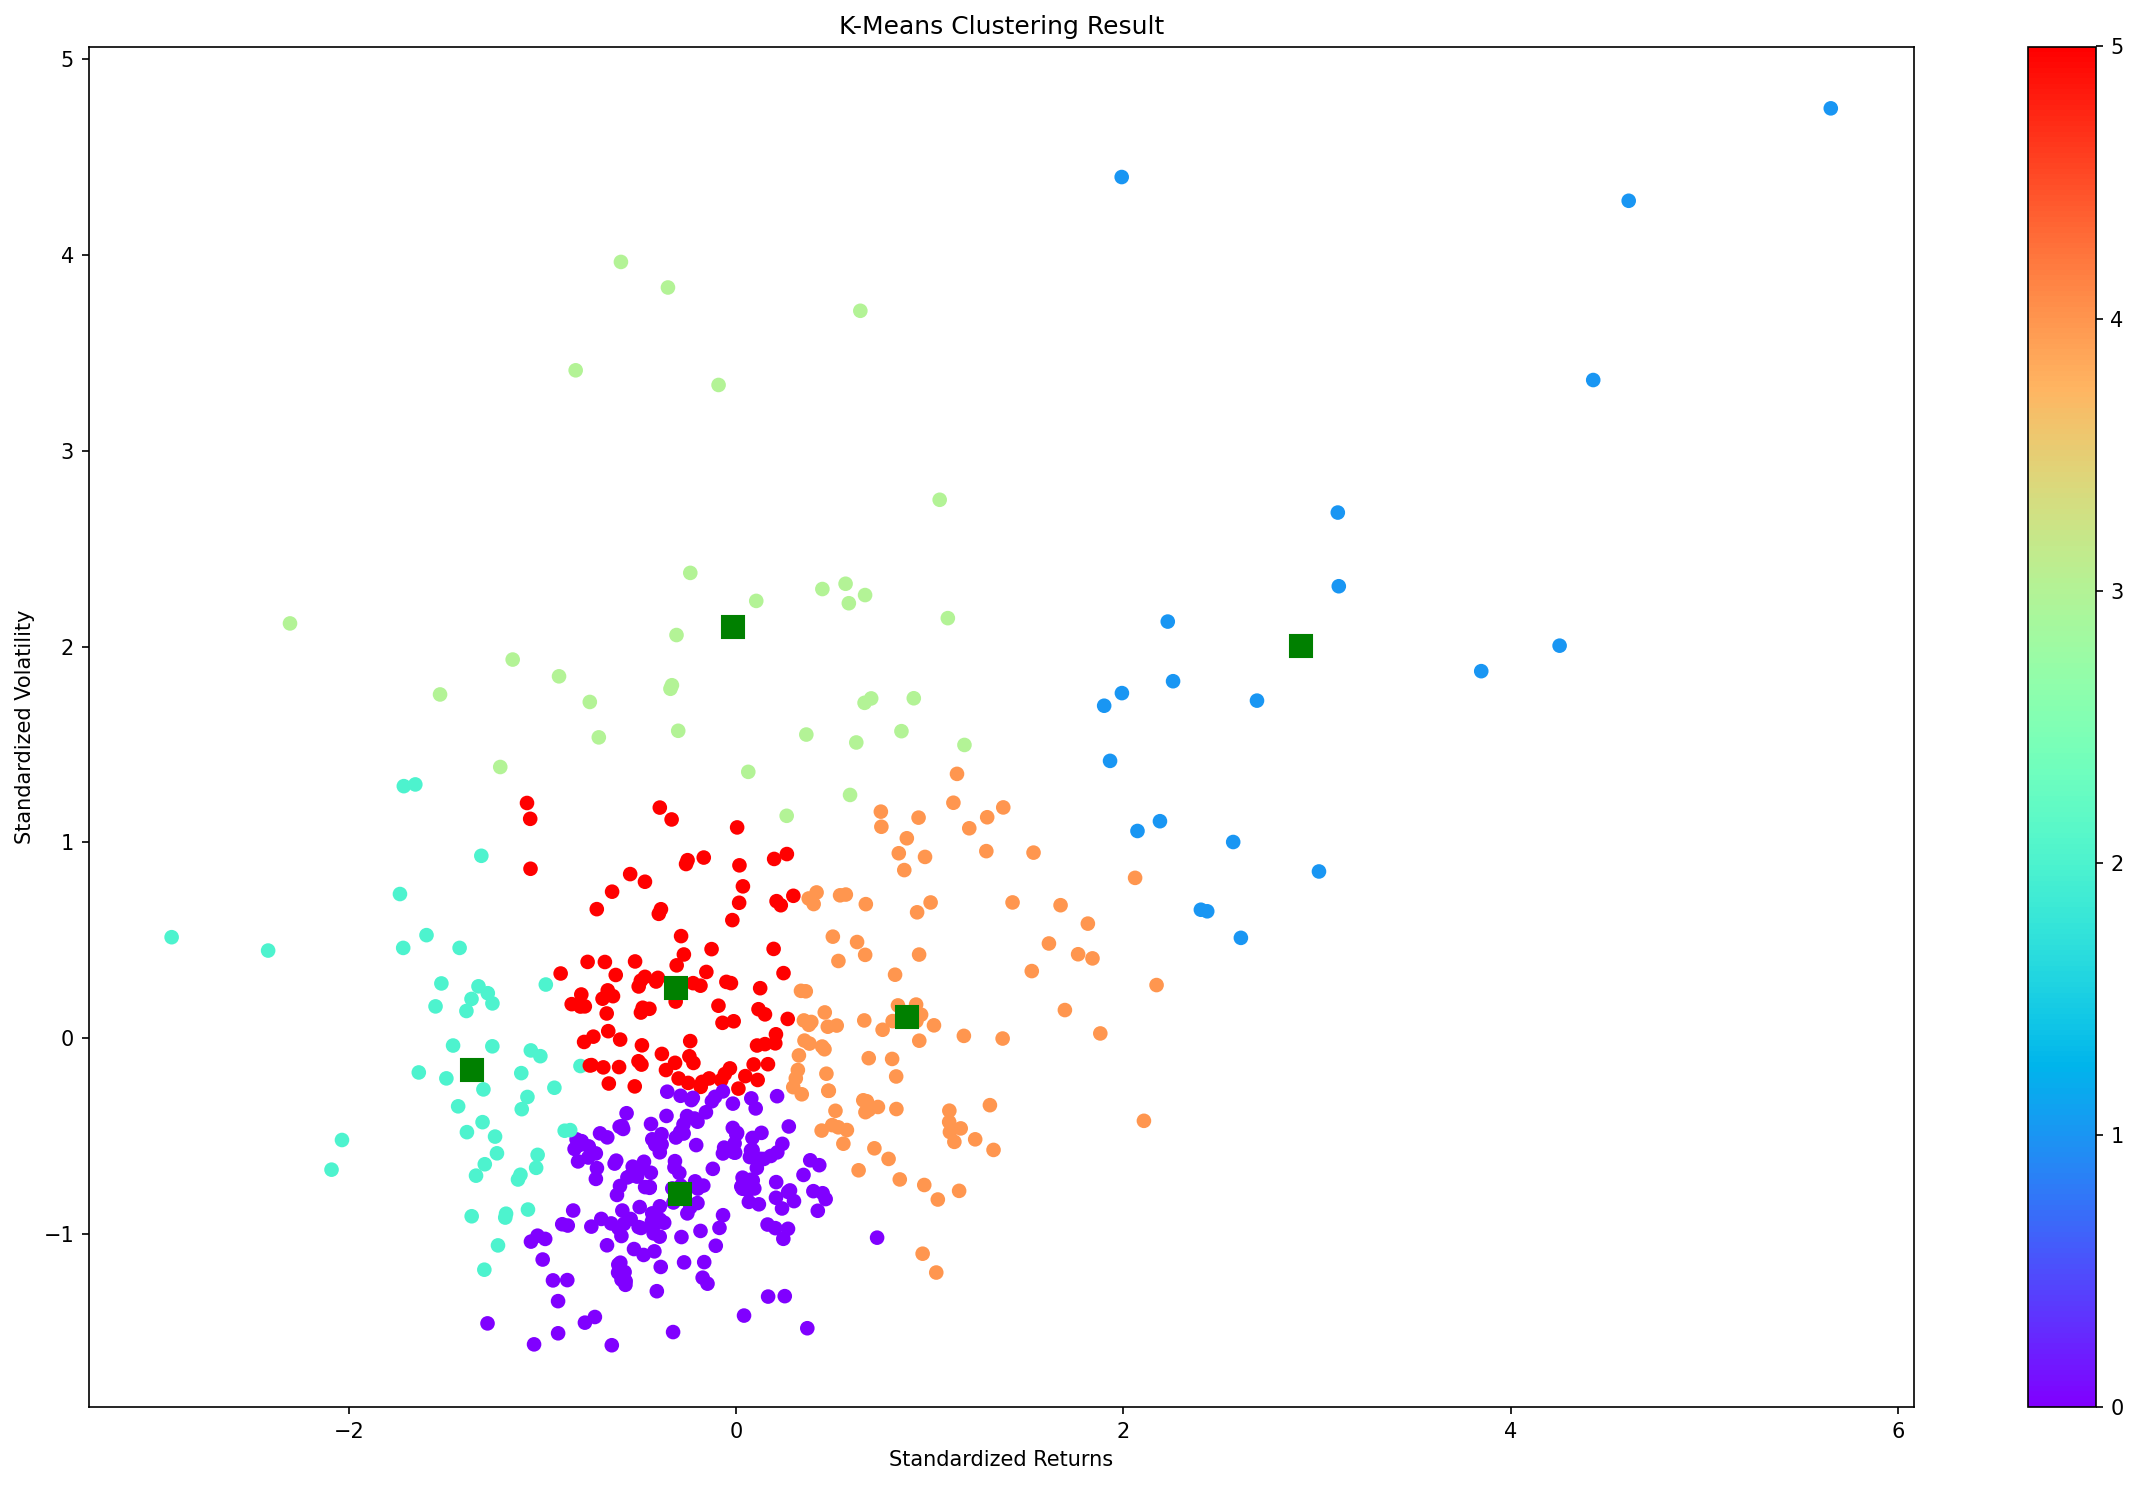

In [15]:
# 當數據集中的變數/維度數量很大時，視覺化聚類的形成並不容易。
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16, 10), dpi=150)
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title('K-Means Clustering Result')
ax.set_xlabel('Standardized Returns')
ax.set_ylabel('Standardized Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=11)
plt.tight_layout()
plt.show()

In [16]:
# 檢查聚類的元素
# 顯示每個聚類中的股票數量
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())

# 帶有聚類標籤的聚類股票
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

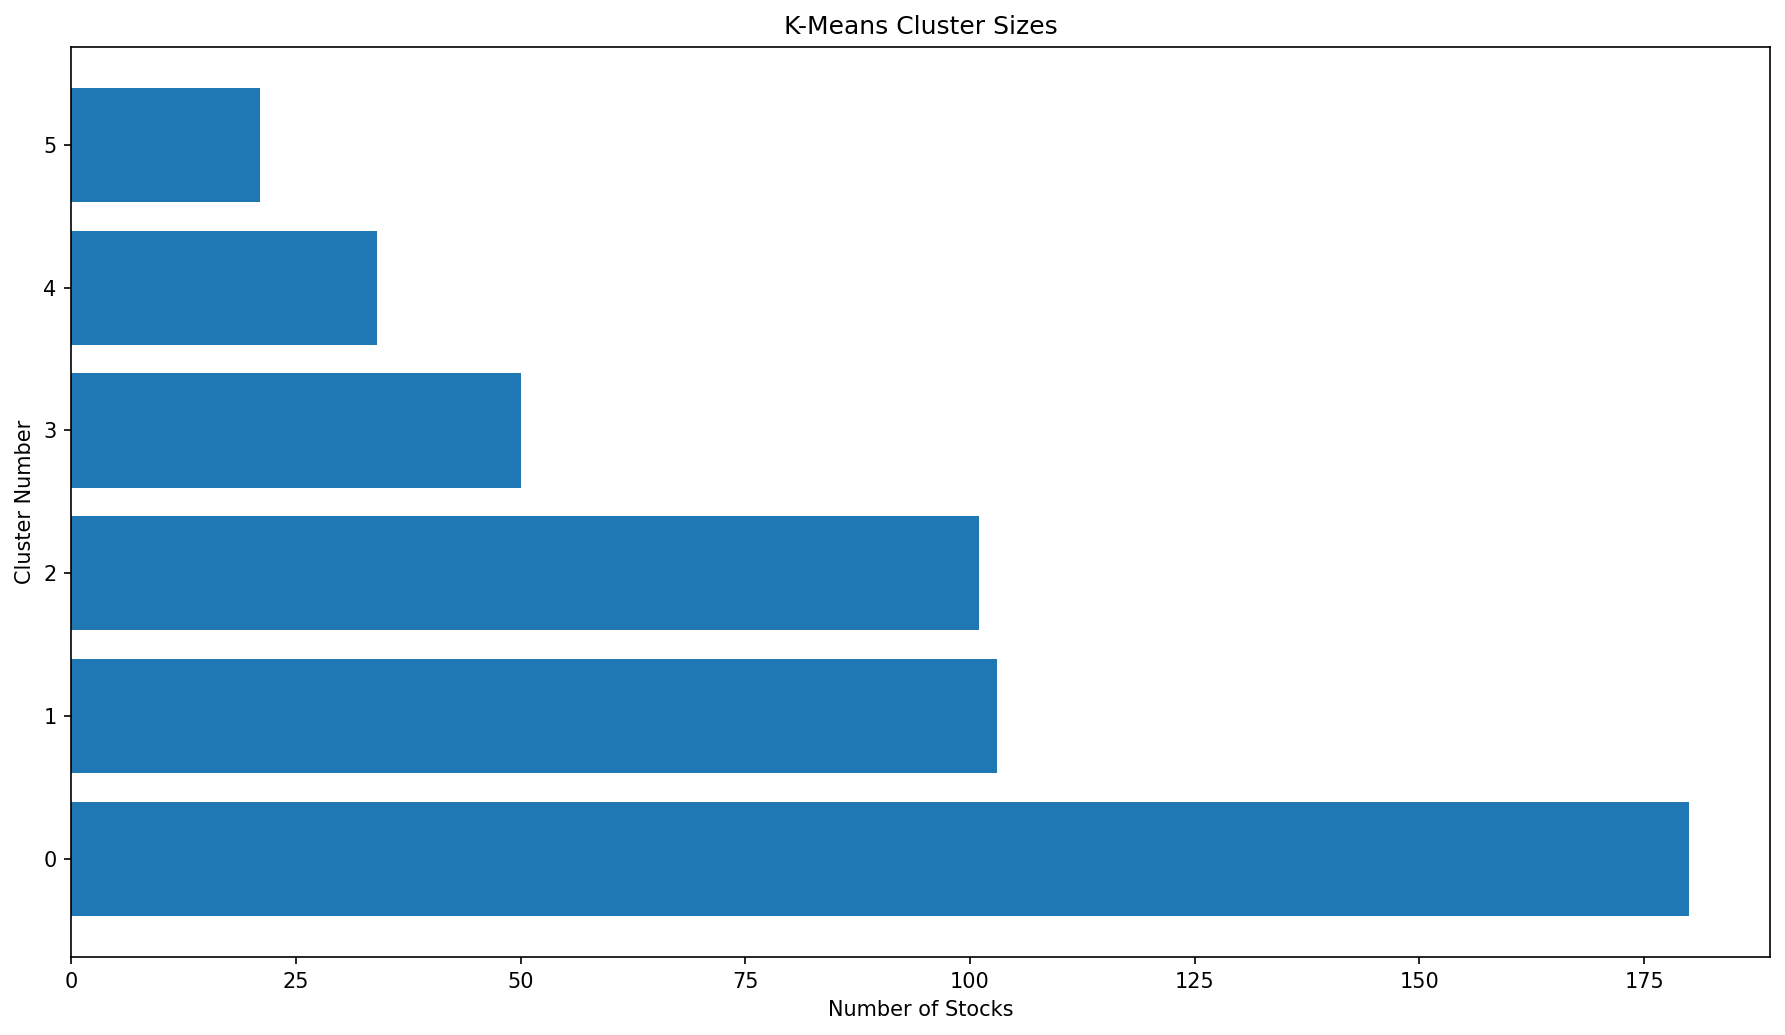

In [17]:
plt.figure(figsize=(12, 7), dpi=150)
plt.barh(
    range(len(clustered_series.value_counts())),  # 聚類標籤，y 軸
    clustered_series.value_counts()
)
plt.title('K-Means Cluster Sizes')
plt.xlabel('Number of Stocks')
plt.ylabel('Cluster Number')
plt.tight_layout()
plt.show()

- 聚類中的股票數量範圍從大約 30 到 150。雖然分佈不均等，但每個聚類中都有大量股票。

## 5. 階層聚類分析（Hierarchical Clustering）
---
### 5.1 樹狀圖分析

**Ward 連結法特點：**

- 最小化聚類內變異數

- 產生較為均勻的聚類

- 適合金融資料分析

In [18]:
# 計算連結
Z = linkage(X, method='ward')
print("Linkage first element:", Z[0])

Linkage first element: [2.230000e+02 2.860000e+02 2.755536e-03 2.000000e+00]


- 視覺化凝聚聚類演算法的最佳方法是通過樹狀圖，葉子是個別股票，根是最終的單一聚類。

- 每個聚類之間的「距離」顯示在 y 軸上，因此分支越長，兩個聚類的相關性越小。

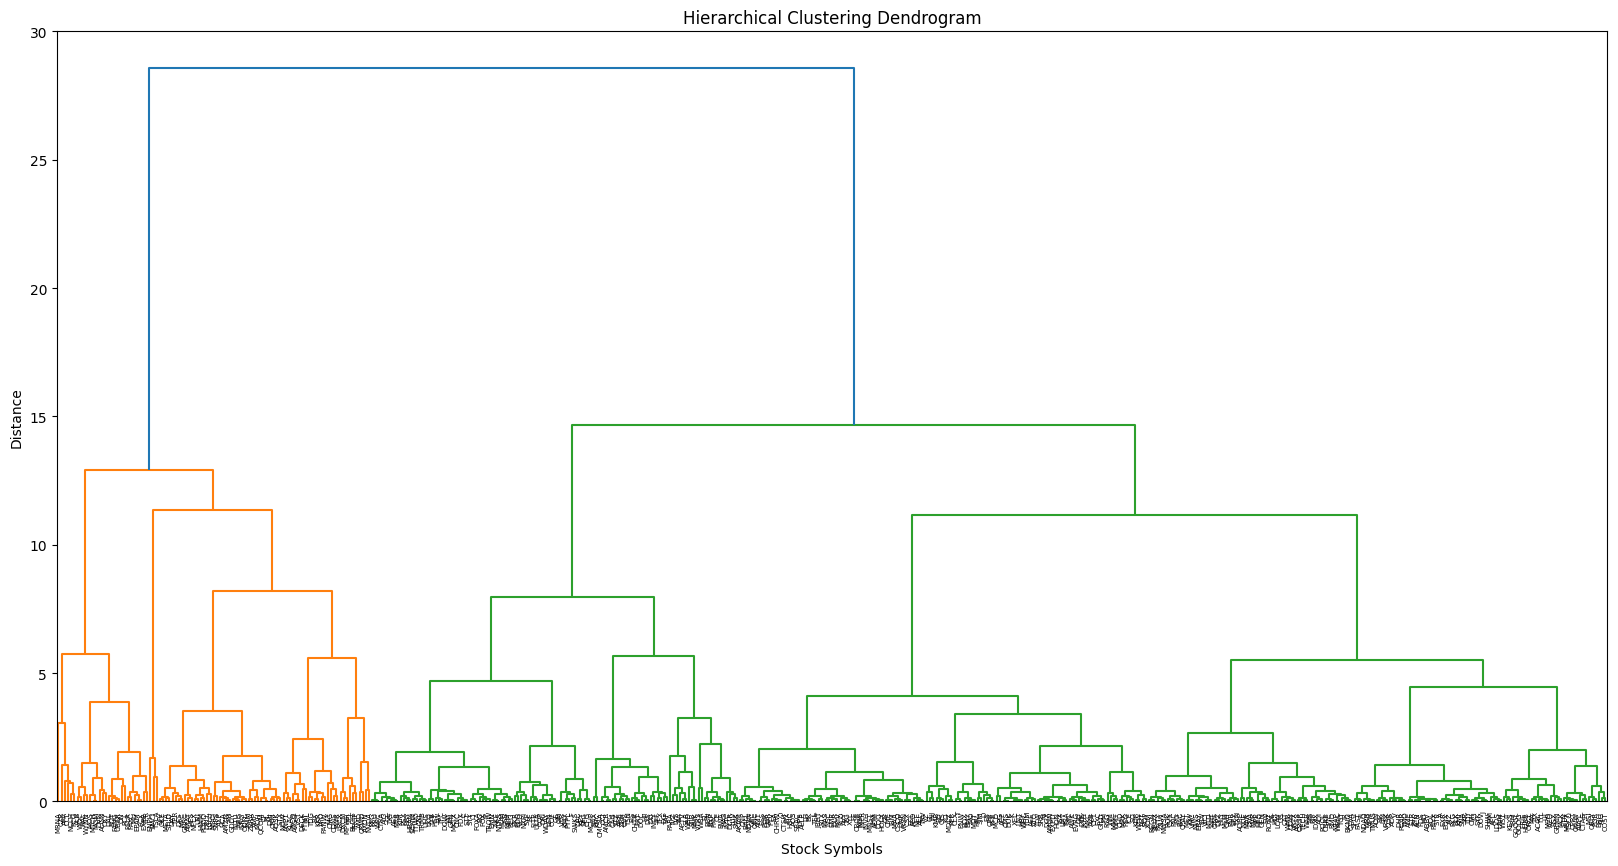

In [19]:
# 繪製樹狀圖
plt.figure(figsize=(20, 10), dpi=100)
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, labels=X.index)
plt.xlabel('Stock Symbols')
plt.ylabel('Distance')
plt.show()

### 5.2 聚類切割

- 選擇適當的距離閾值

- 通過樹狀圖視覺判斷

- 確保聚類數量合理

In [20]:
# 距離閾值
distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
print("Unique clusters:", chosen_clusters['cluster'].unique())

Unique clusters: [3 1 2]


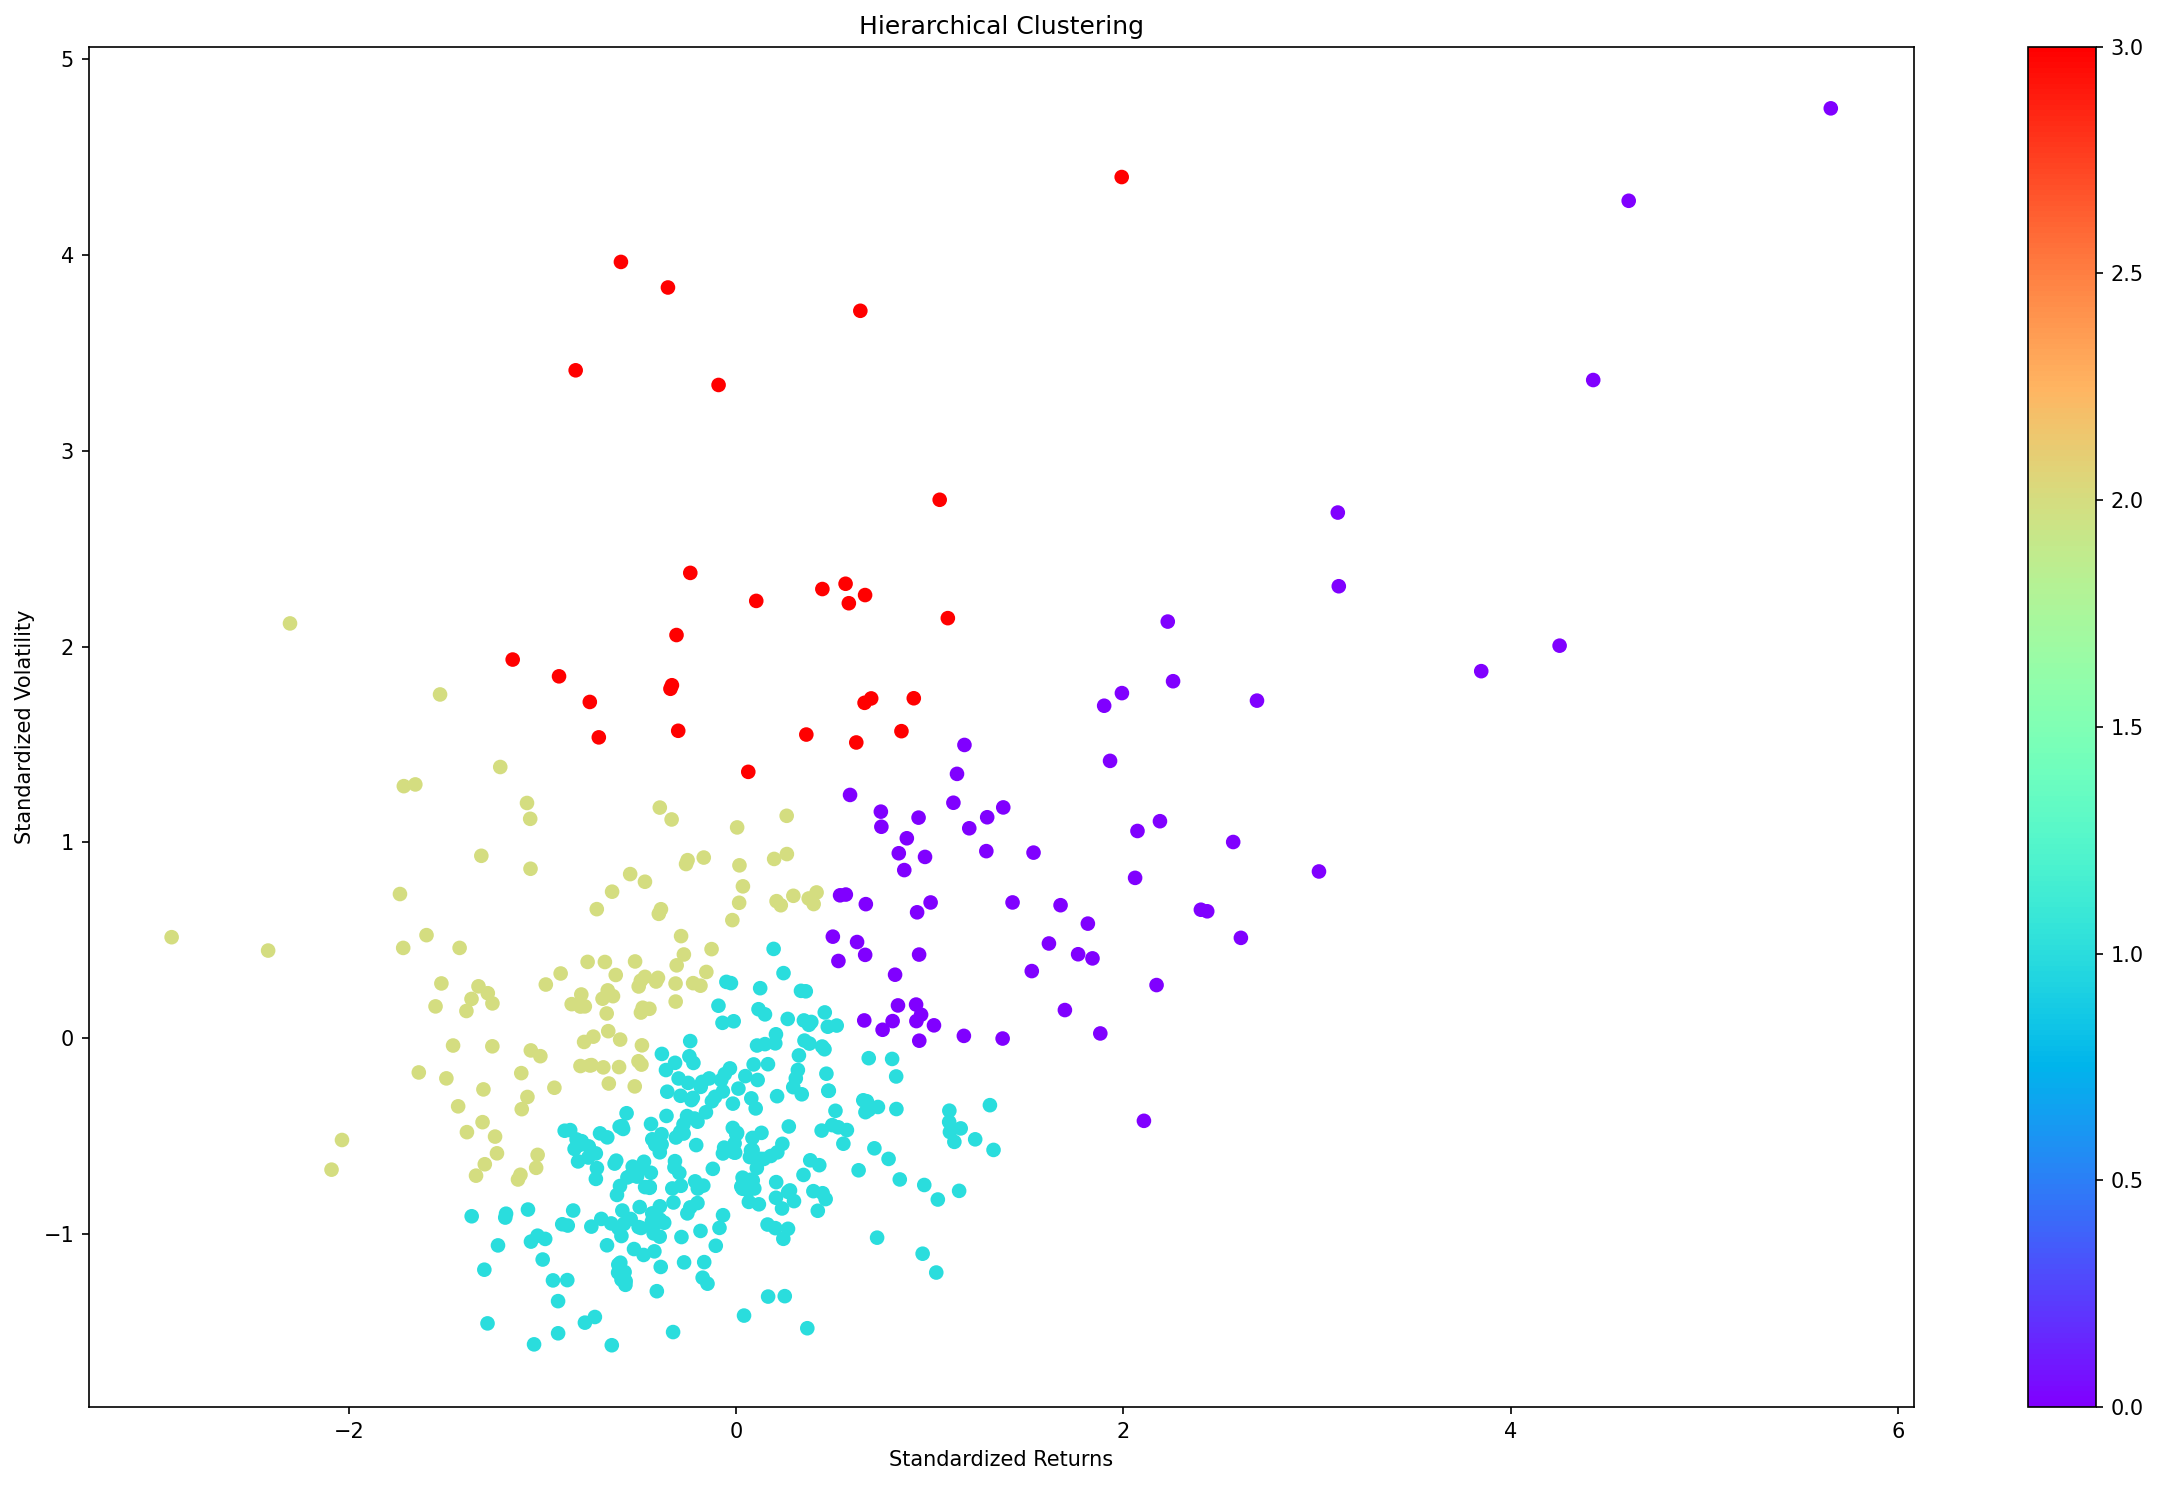

In [21]:
# 聚類數量
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, linkage='ward')
clust_labels1 = hc.fit_predict(X)

fig = plt.figure(figsize=(16, 10), dpi=150)
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels1, cmap="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Standardized Returns')
ax.set_ylabel('Standardized Volatility')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

## 6. 親和力傳播聚類（Affinity Propagation Clustering）
---
### 6.1 演算法特點

- 自動確定聚類數量

- 不需要預先指定聚類中心

- 適合發現自然的資料群組

In [22]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

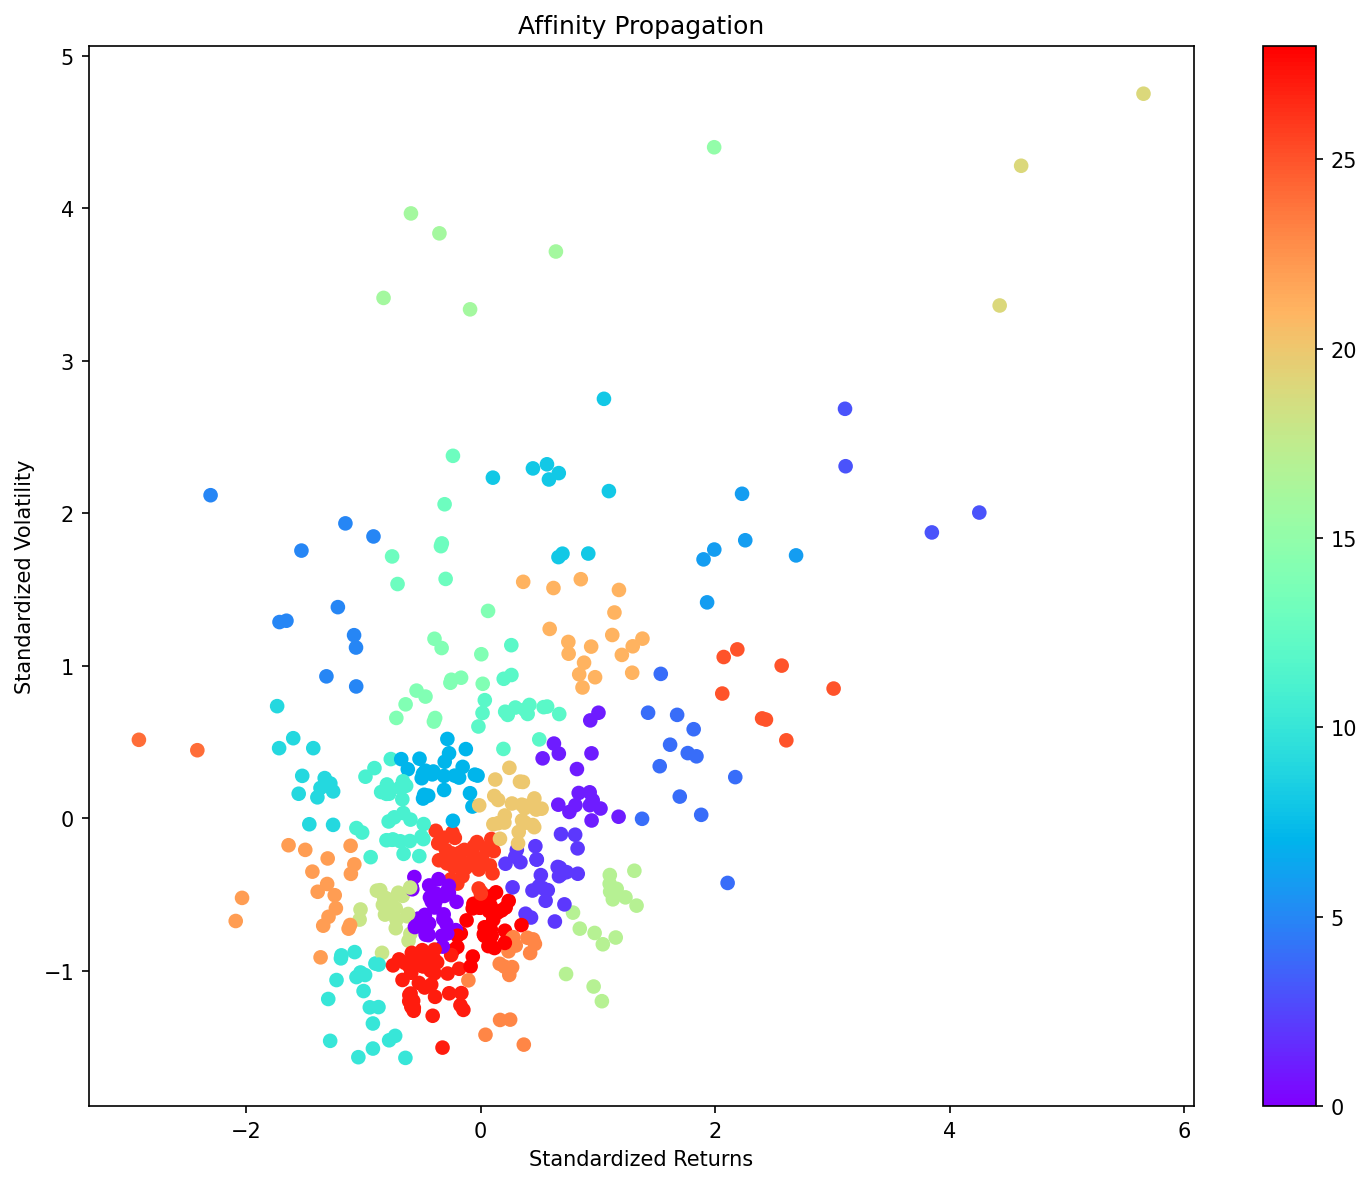

In [23]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels2, cmap="rainbow")
ax.set_title('Affinity Propagation')
ax.set_xlabel('Standardized Returns')
ax.set_ylabel('Standardized Volatility')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

### 6.2 聚類中心識別

每個聚類的代表性樣本，有助於理解聚類特性。

In [24]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 29


<Figure size 640x480 with 0 Axes>

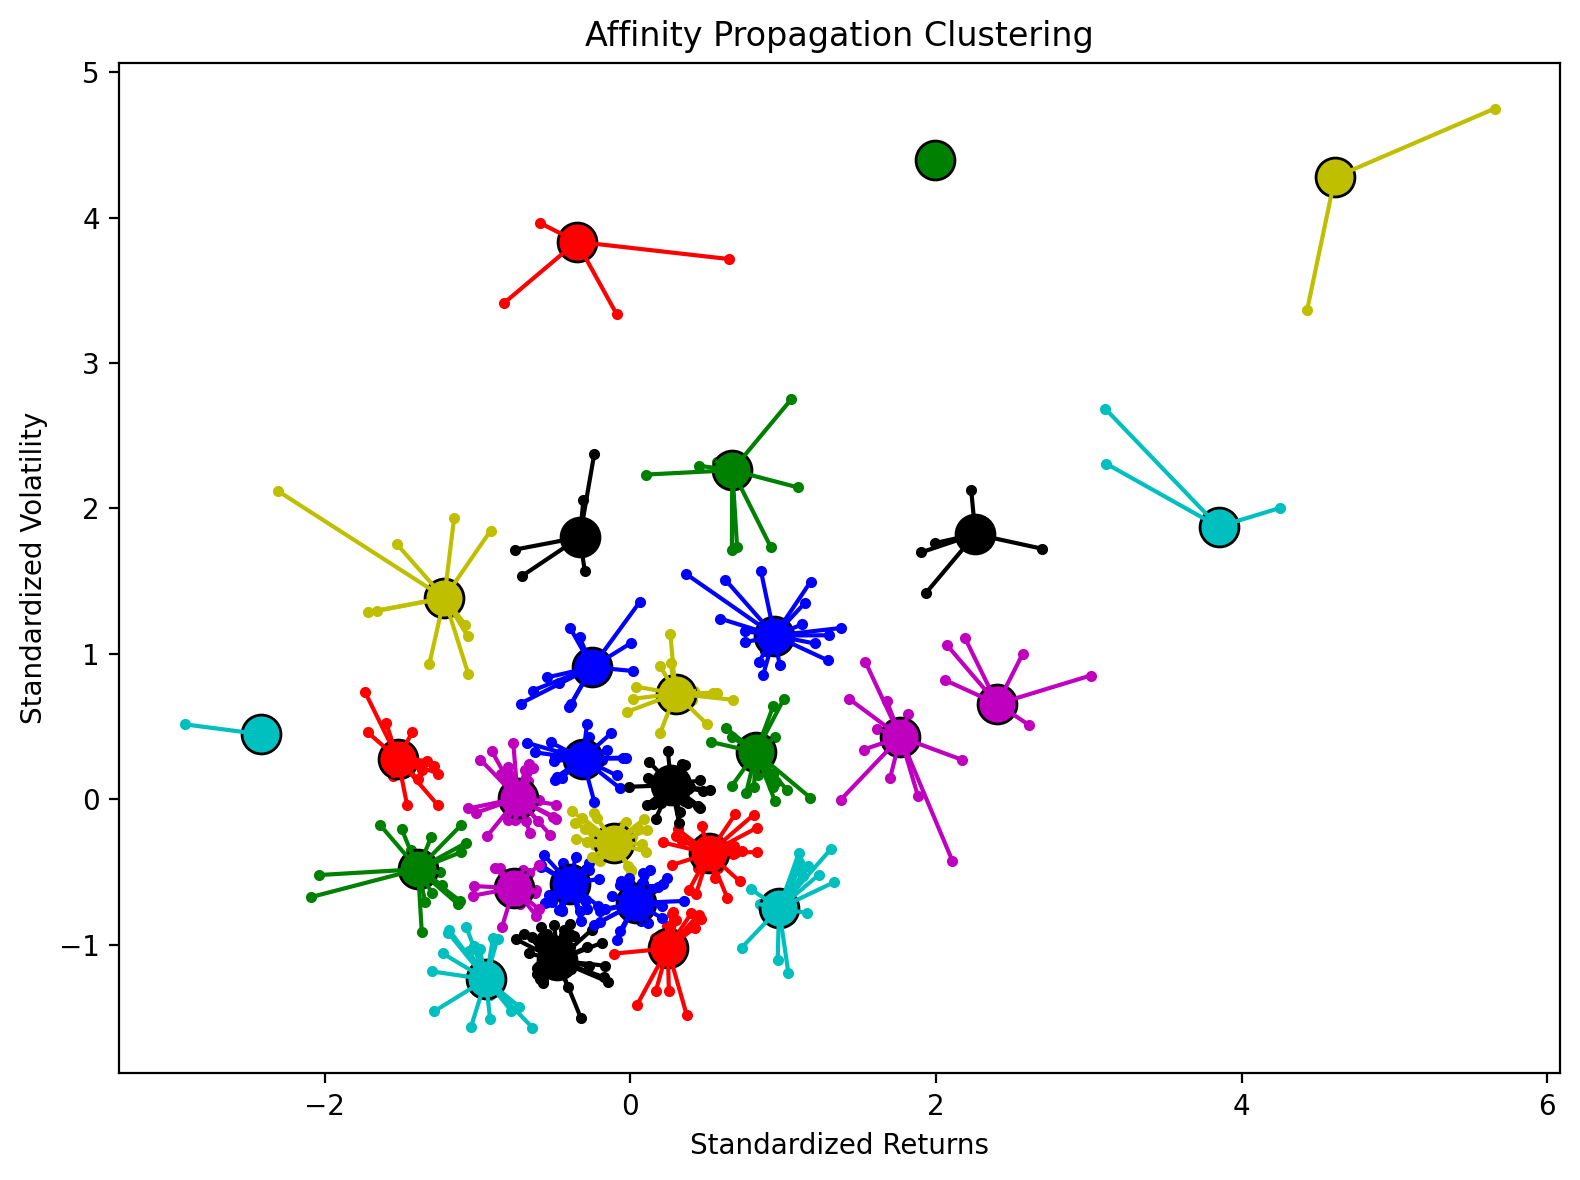

In [25]:
# 繪製範例
X_temp = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8, 6), dpi=200)
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering')
plt.xlabel('Standardized Returns')
plt.ylabel('Standardized Volatility')
plt.tight_layout()
plt.show()

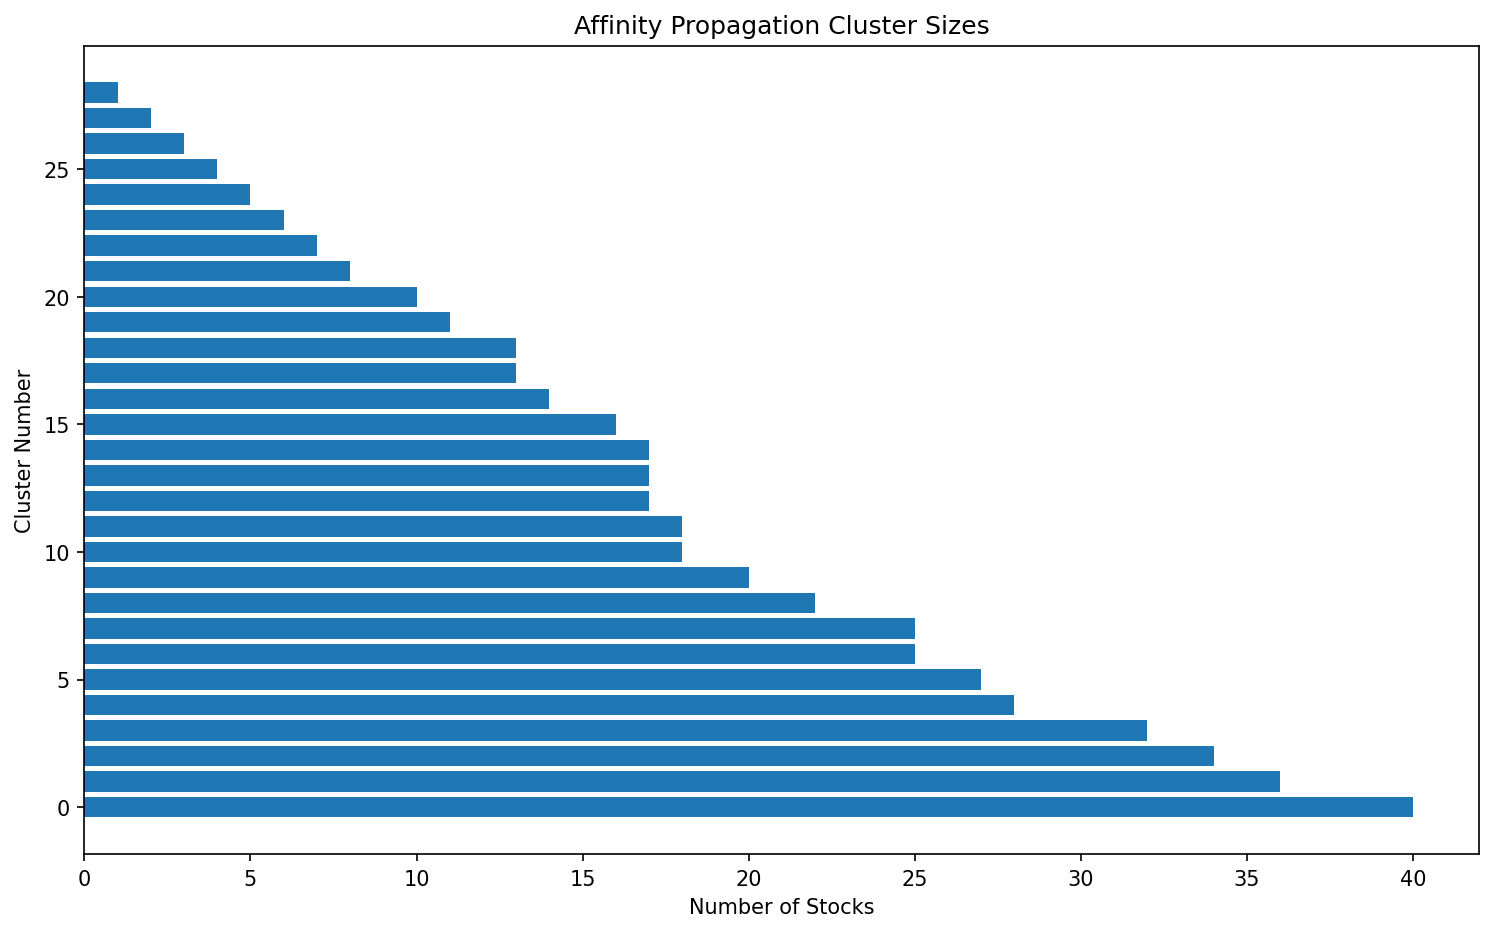

In [26]:
# 顯示每個聚類中的股票數量
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

# 帶有聚類標籤的聚類股票
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12, 7), dpi=150)
plt.barh(
    range(len(clustered_series_ap.value_counts())),  # 聚類標籤，y 軸
    clustered_series_ap.value_counts()
)
plt.title('Affinity Propagation Cluster Sizes')
plt.xlabel('Number of Stocks')
plt.ylabel('Cluster Number')
plt.show()

## 7. 聚類效果評估
---
### 7.1 輪廓係數比較

- 如果不知道真實標籤，則必須使用模型本身進行評估。

- 輪廓係數（sklearn.metrics.silhouette_score）是此類評估的一個例子，其中較高的輪廓係數分數與具有更好定義聚類的模型相關。

In [27]:
print("K-means silhouette score:", f"{metrics.silhouette_score(X, k_means.labels_, metric='euclidean'):.4f}")
print("Hierarchical silhouette score:", f"{metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'):.4f}")
print("Affinity Propagation silhouette score:", f"{metrics.silhouette_score(X, ap.labels_, metric='euclidean'):.4f}")

K-means silhouette score: 0.3365
Hierarchical silhouette score: 0.3370
Affinity Propagation silhouette score: 0.3550


### 7.2 方法選擇

- Affinity Propagation（親和力傳播）表現最佳，我們繼續使用親和力傳播，並使用此聚類方法指定的聚類

In [28]:
# 所有股票及其聚類標籤（包括 -1）
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())

# 帶有聚類標籤的聚類股票
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

# 獲取每個聚類中的股票數量
counts = clustered_series_ap.value_counts()

In [29]:
# 讓我們視覺化一些聚類
cluster_vis_list = list(counts[(counts < 25) & (counts > 1)].index)[::-1]
print("Cluster visualization list:", cluster_vis_list)

CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1) & (counts <= CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced * (ticker_count_reduced - 1)).sum())

Cluster visualization list: [24, 19, 3, 16, 6, 13, 25, 8, 5, 9, 4, 14, 17, 12, 1, 23, 22, 21, 10, 18]
Clusters formed: 28
Pairs to evaluate: 10964


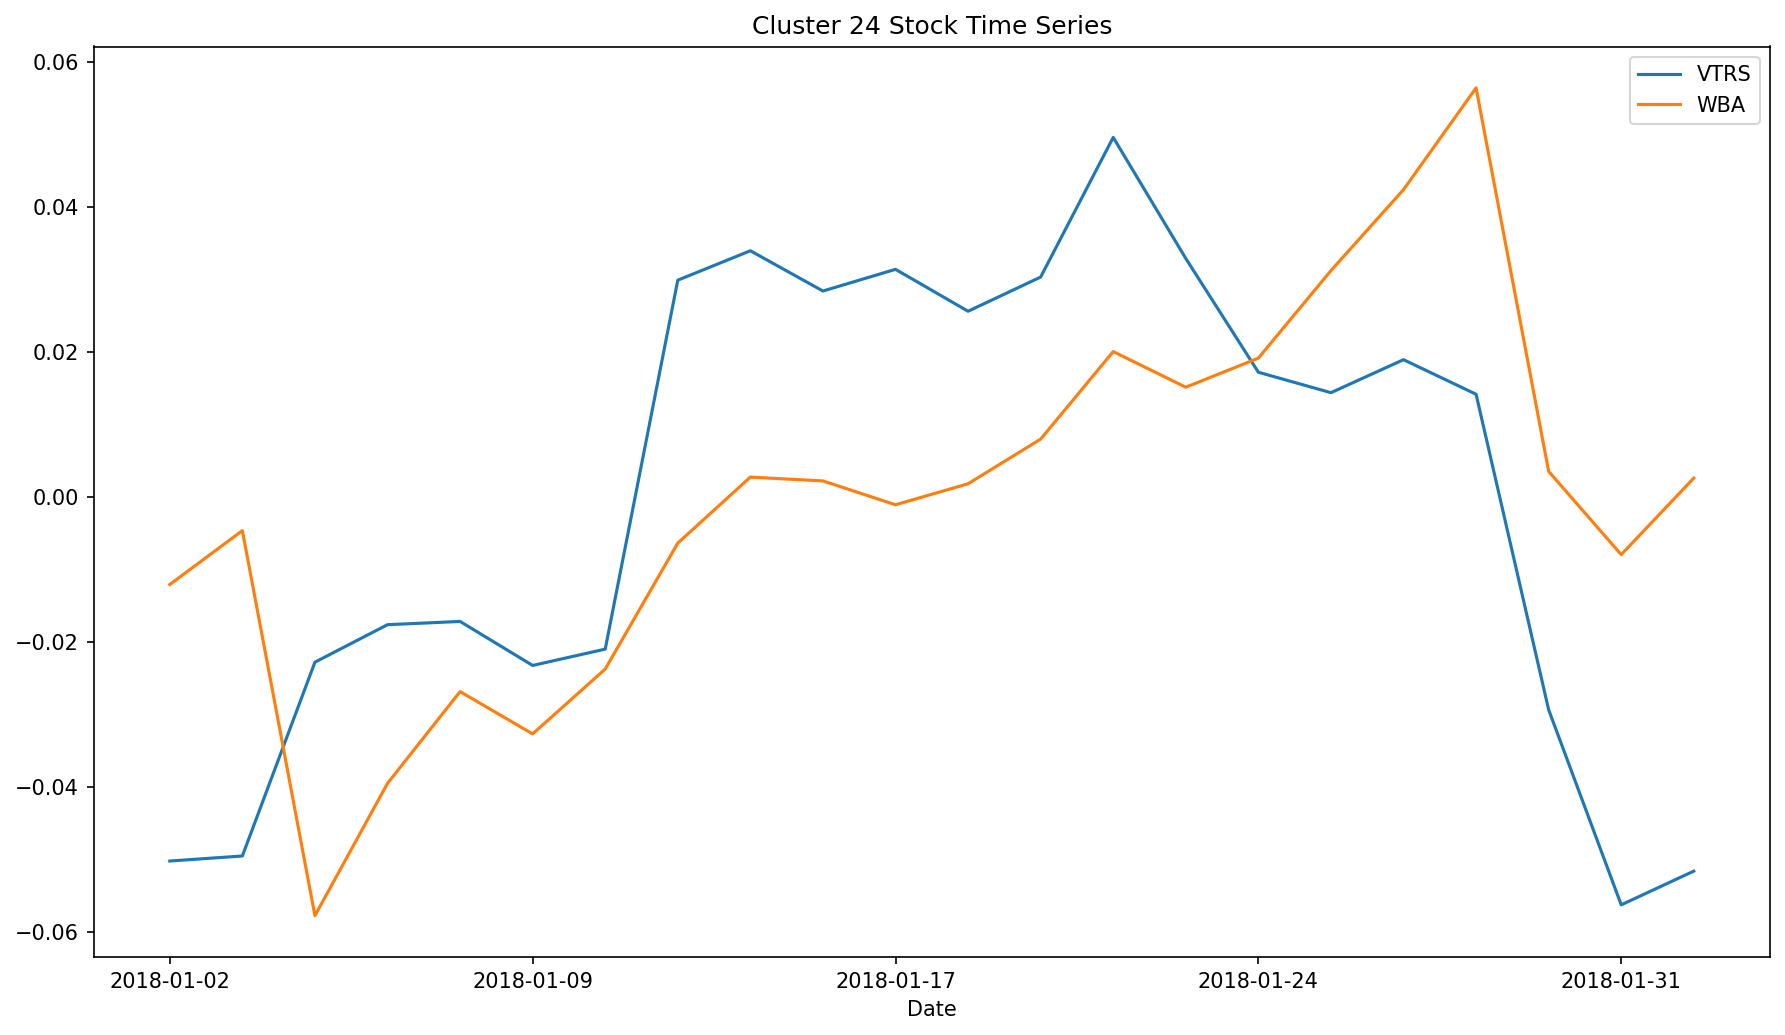

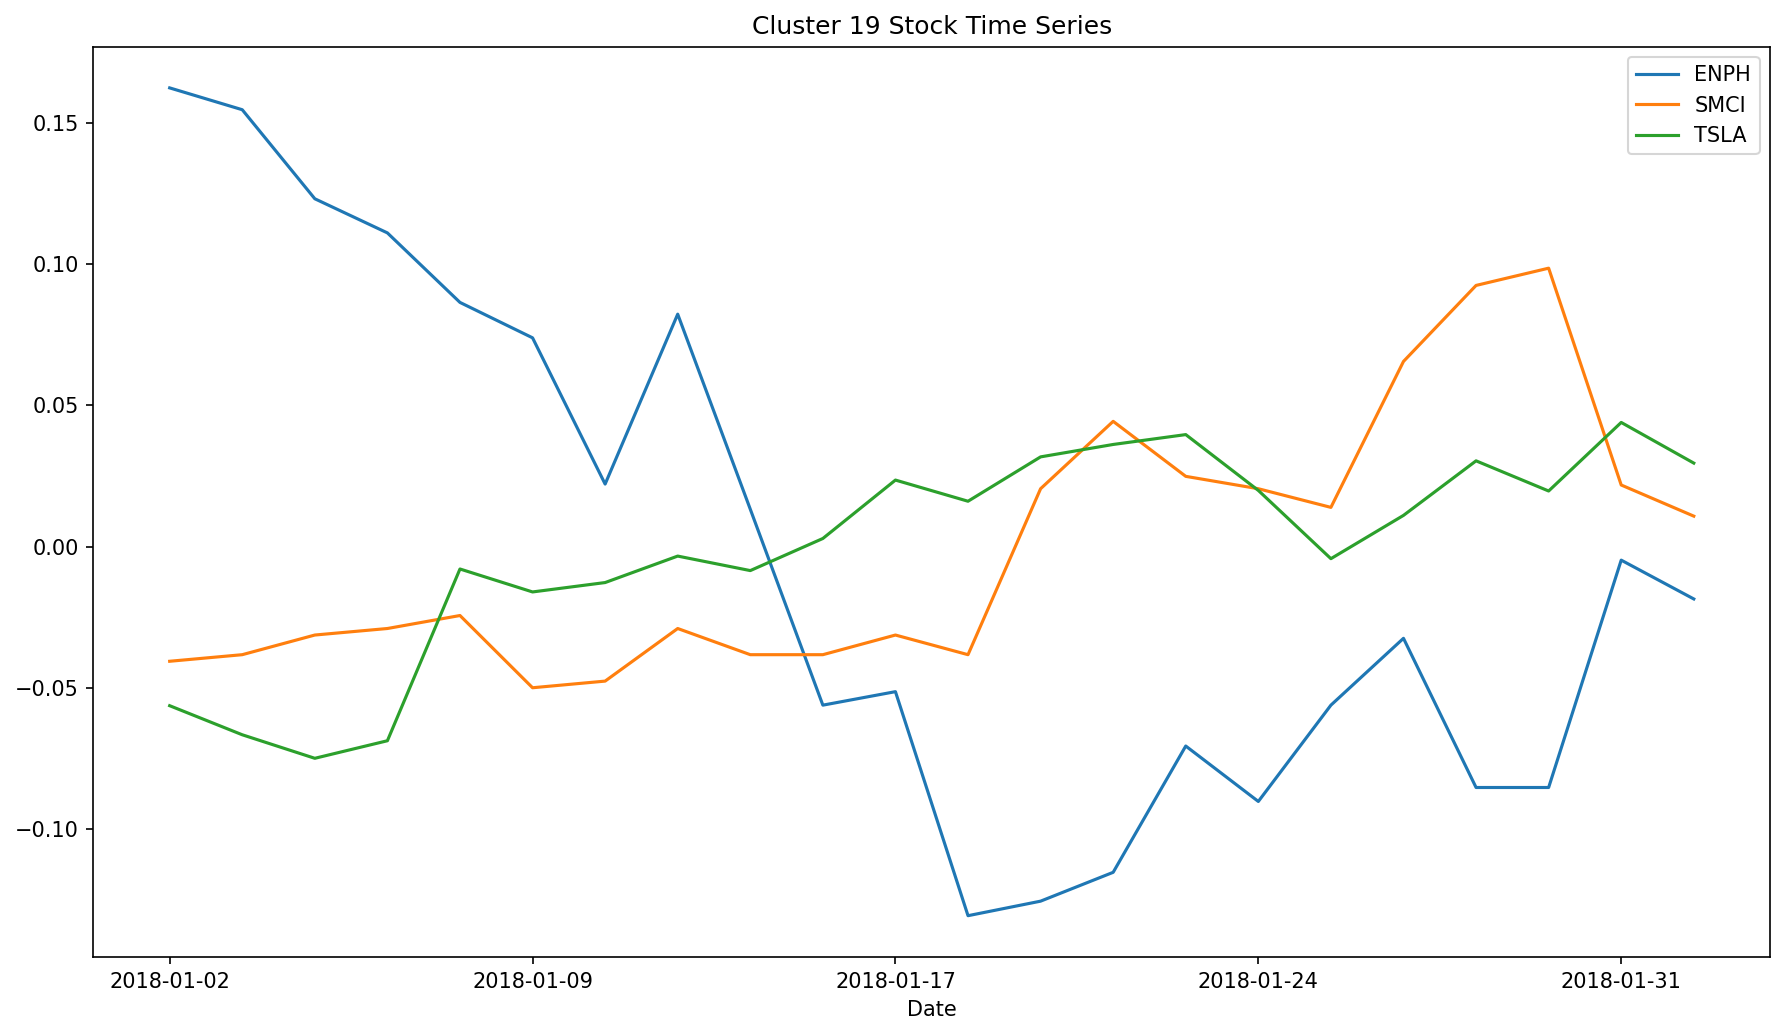

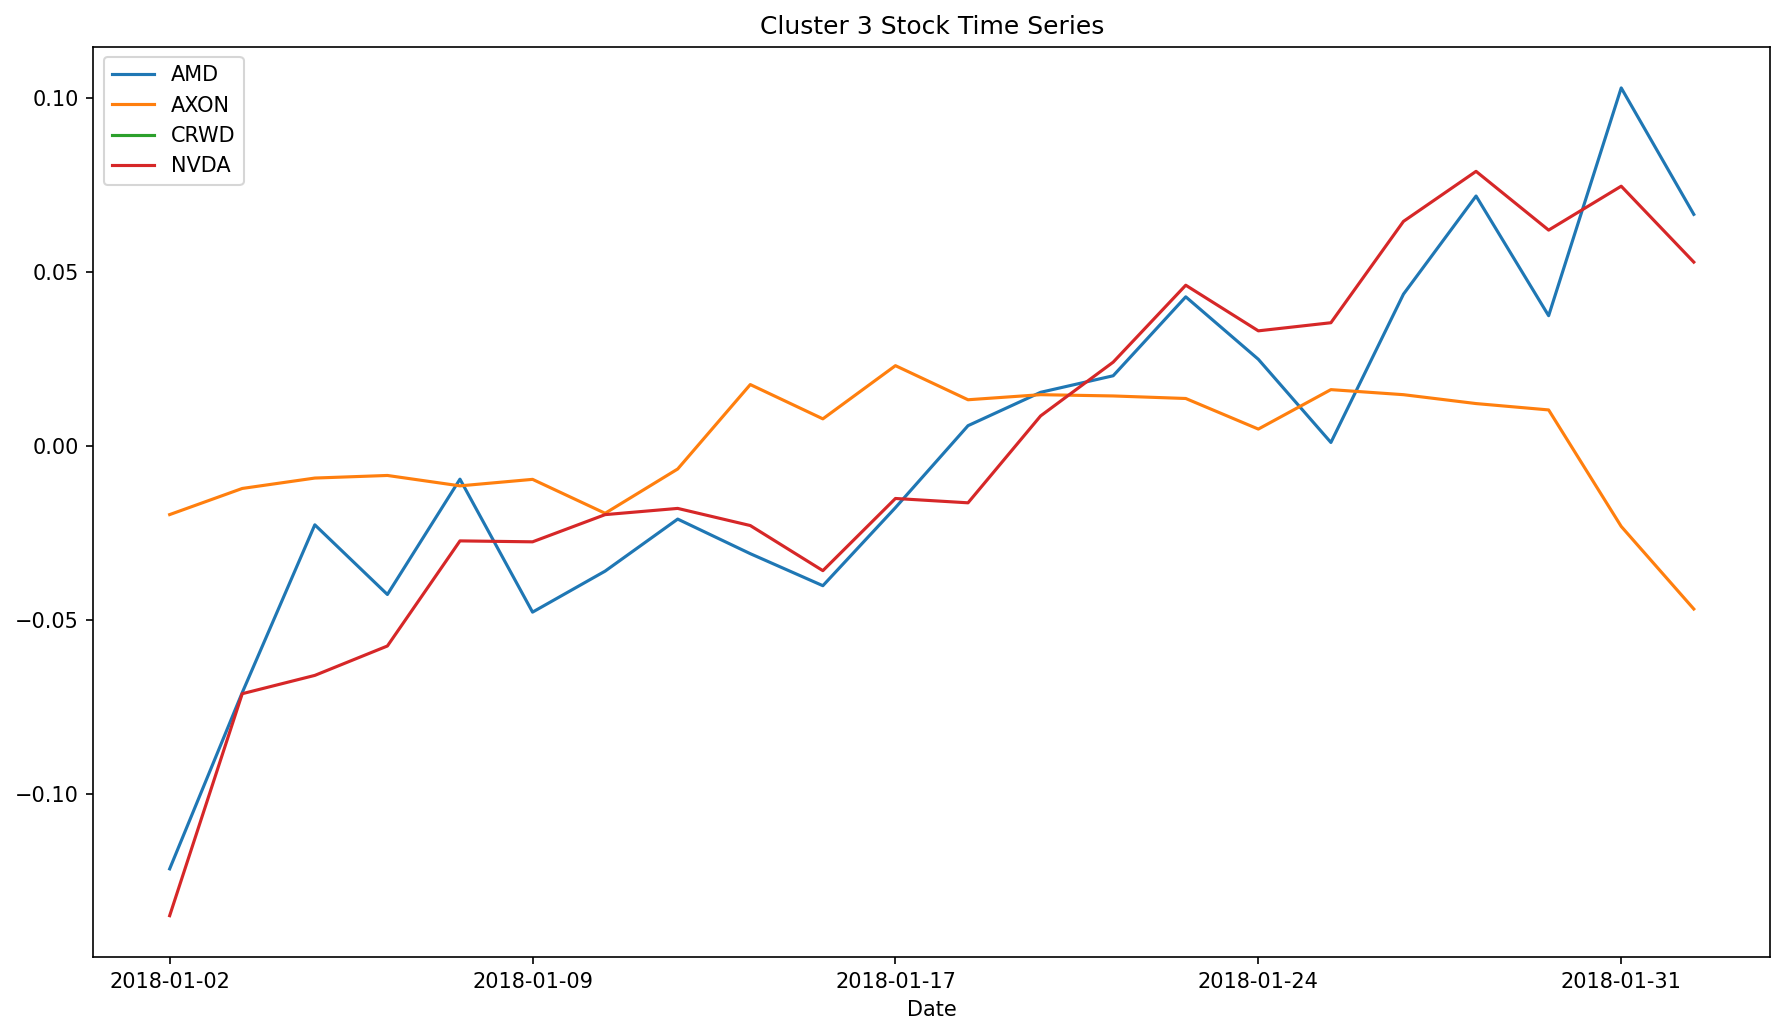

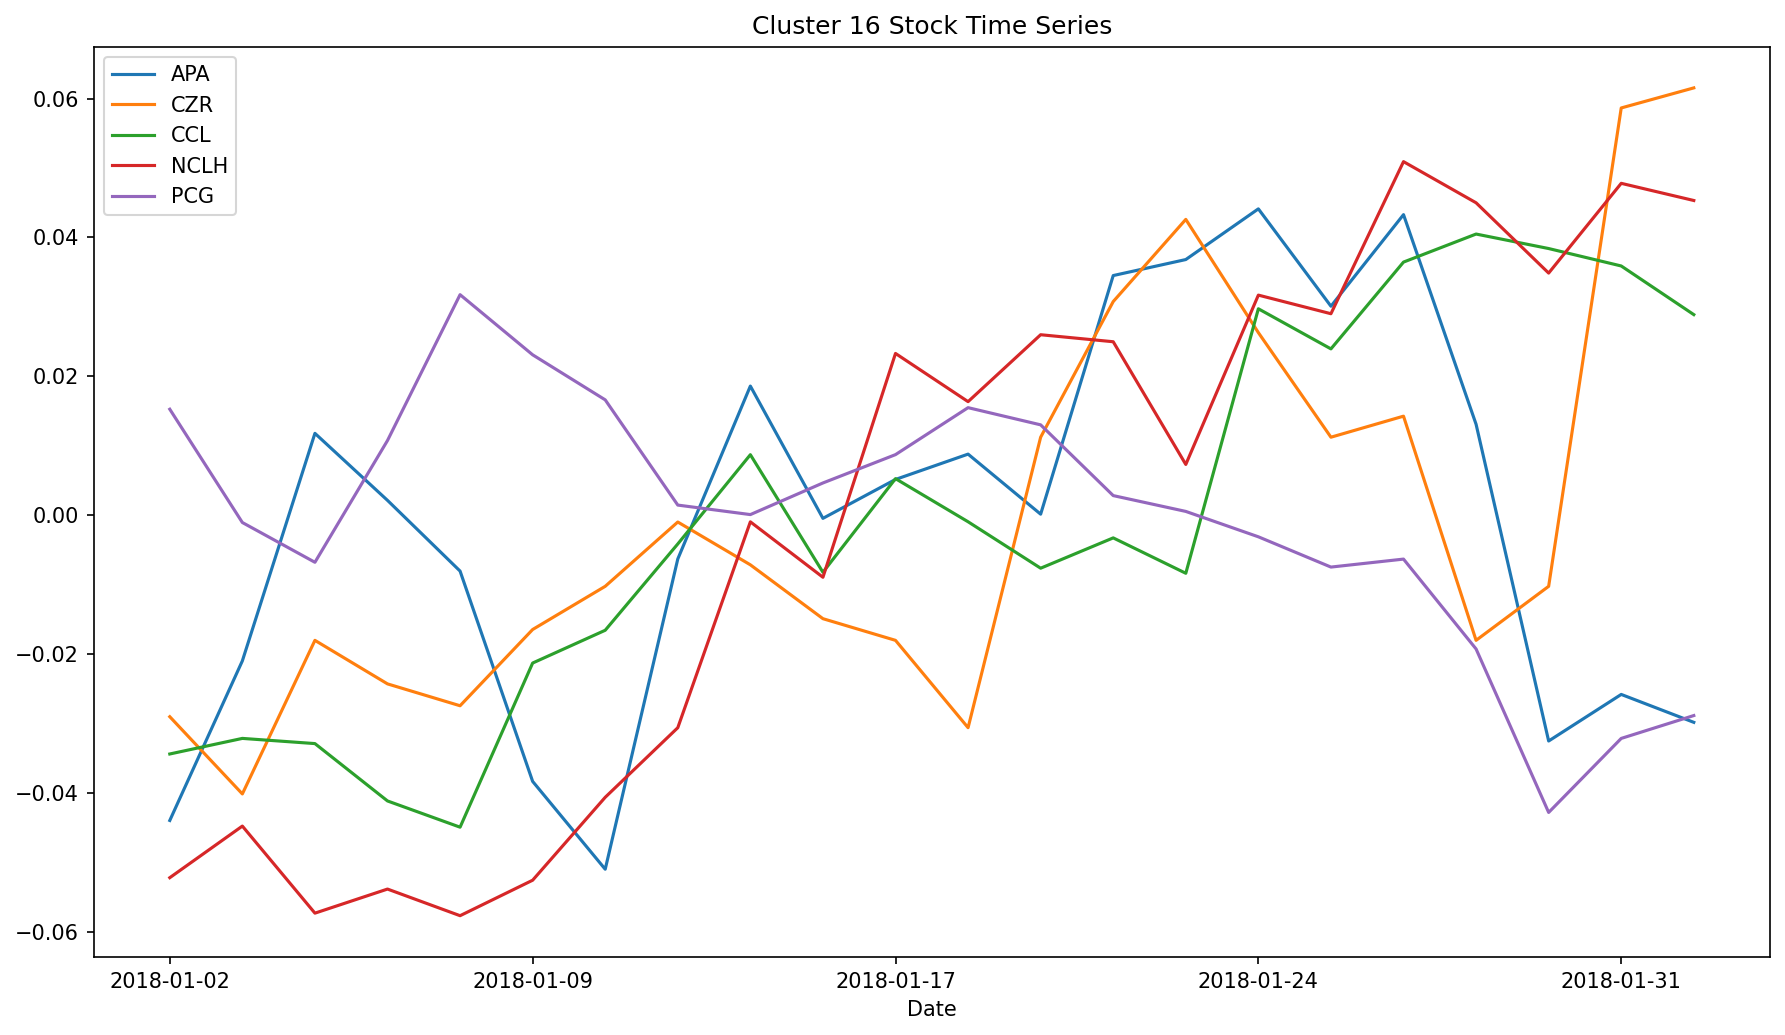

In [30]:
# 繪製一些最小的聚類
cluster_vis_list_subset = cluster_vis_list[0:min(len(cluster_vis_list), 4)]

for clust in cluster_vis_list_subset:
    tickers = list(clustered_series[clustered_series == clust].index)
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    data_plot = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    ax = data_plot.plot(title='Cluster %d Stock Time Series' % clust, figsize=(12, 7))
    ax.figure.set_dpi(150)
    plt.tight_layout()
    plt.show()

- 查看上面的圖表，在股票數量較少的聚類中，我們看到股票的相似移動，這證實了聚類技術的有效性。

## 8. 配對選擇與共整合檢驗
---
### 8.1 共整合檢驗函數

- 標準版本

    **功能：**
    - 對聚類內的股票進行兩兩共整合檢驗

    - 識別具有長期均衡關係的股票對
    
    - 適用於配對交易策略

- 快速版本

    **優化特點：**
    - 使用隨機抽樣減少計算量
    
    - 適用於大型聚類
    
    - 提高計算效率

In [31]:
def find_cointegrated_pairs(data, significance=0.05, max_pairs=None, verbose=True):
    """
    優化版本的共整合配對尋找函數
    
    Parameters:
    - data: 股票價格數據
    - significance: 顯著性水準 (預設 0.05)
    - max_pairs: 最大配對數量限制 (可選，用於早期停止)
    - verbose: 是否顯示進度
    """
    import time
    
    n = data.shape[1]
    keys = list(data.keys())
    pairs = []
    
    # 預先清理數據，避免重複處理
    cleaned_data = {}
    for key in keys:
        series = data[key].replace([np.inf, -np.inf], np.nan).dropna()
        cleaned_data[key] = series
    
    total_pairs = n * (n - 1) // 2
    if verbose:
        print(f"Testing {total_pairs} potential pairs...")
    
    start_time = time.time()
    tested_pairs = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            key1, key2 = keys[i], keys[j]
            tested_pairs += 1
            
            try:
                S1 = cleaned_data[key1]
                S2 = cleaned_data[key2]
                
                # 找到共同的時間索引
                common_index = S1.index.intersection(S2.index)
                if len(common_index) < 30:  # 需要足夠的數據點
                    continue
                    
                S1_aligned = S1.loc[common_index]
                S2_aligned = S2.loc[common_index]
                
                # 執行共整合檢驗
                result = coint(S1_aligned, S2_aligned)
                pvalue = result[1]
                
                if pvalue < significance:
                    pairs.append((key1, key2))
                    if verbose and len(pairs) % 5 == 0:
                        elapsed = time.time() - start_time
                        progress = tested_pairs / total_pairs * 100
                        print(f"Progress: {progress:.1f}% - Found {len(pairs)} pairs (Elapsed: {elapsed:.1f}s)")
                
                # 早期停止機制
                if max_pairs and len(pairs) >= max_pairs:
                    if verbose:
                        print(f"Reached maximum pairs limit ({max_pairs}), stopping early.")
                    break
                    
            except Exception as e:
                if verbose:
                    print(f"Error testing pair ({key1}, {key2}): {e}")
                continue
        
        # 檢查是否需要早期停止
        if max_pairs and len(pairs) >= max_pairs:
            break
    
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Completed in {elapsed_time:.1f} seconds. Found {len(pairs)} cointegrated pairs.")
    
    # 為了相容性，仍然返回矩陣（但只填充找到的配對）
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    return score_matrix, pvalue_matrix, pairs


def find_cointegrated_pairs_fast(data, significance=0.05, sample_size=None, verbose=True):
    """
    快速版本：使用取樣方法減少計算量
    
    Parameters:
    - data: 股票價格數據
    - significance: 顯著性水準
    - sample_size: 取樣大小（如果為None，則測試所有配對）
    - verbose: 是否顯示進度
    """
    import random
    import time
    
    n = data.shape[1]
    keys = list(data.keys())
    pairs = []
    
    # 生成所有可能的配對
    all_combinations = [(i, j) for i in range(n) for j in range(i + 1, n)]
    
    # 如果指定了取樣大小，則隨機取樣
    if sample_size and sample_size < len(all_combinations):
        combinations_to_test = random.sample(all_combinations, sample_size)
        if verbose:
            print(f"Randomly sampling {sample_size} pairs out of {len(all_combinations)} total combinations")
    else:
        combinations_to_test = all_combinations
    
    if verbose:
        print(f"Testing {len(combinations_to_test)} pairs for cointegration...")
    
    start_time = time.time()
    
    for idx, (i, j) in enumerate(combinations_to_test):
        try:
            S1 = data[keys[i]].replace([np.inf, -np.inf], np.nan).dropna()
            S2 = data[keys[j]].replace([np.inf, -np.inf], np.nan).dropna()
            
            # 找到共同的時間索引
            common_index = S1.index.intersection(S2.index)
            if len(common_index) < 30:  # 需要足夠的數據點
                continue
                
            S1_aligned = S1.loc[common_index]
            S2_aligned = S2.loc[common_index]
            
            result = coint(S1_aligned, S2_aligned)
            pvalue = result[1]
            
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
            
            # 進度顯示
            if verbose and (idx + 1) % 100 == 0:
                elapsed = time.time() - start_time
                progress = (idx + 1) / len(combinations_to_test) * 100
                print(f"Progress: {progress:.1f}% ({idx + 1}/{len(combinations_to_test)}) - Found {len(pairs)} pairs (Elapsed: {elapsed:.1f}s)")
                
        except Exception as e:
            if verbose:
                print(f"Error testing pair ({keys[i]}, {keys[j]}): {e}")
            continue
    
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Completed in {elapsed_time:.1f} seconds. Found {len(pairs)} cointegrated pairs.")
    
    # 為了相容性，返回空矩陣
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    return score_matrix, pvalue_matrix, pairs

### 8.2 共整合檢驗原理

**什麼是共整合？**
- 兩個非穩定時間序列的線性組合是穩定的

- 表示兩支股票存在長期均衡關係

- 短期偏離會回歸到均衡狀態

**在配對交易中的應用：**
- 當股價偏離歷史關係時進行交易

- 做多被低估的股票，做空被高估的股票

- 等待價格關係回歸正常獲利

### 8.3 配對篩選流程

**步驟：**
1. 遍歷每個聚類

2. 在聚類內進行配對檢驗

3. 收集所有顯著的配對

4. 統計分析結果

In [32]:
# 選擇優化方法
USE_FAST_METHOD = True  # 設為 True 使用快速取樣方法，False 使用平行處理方法
SAMPLE_SIZE = 1000      # 快速方法的取樣大小
MAX_PAIRS = 50          # 平行處理方法的最大配對數限制

print(f"\n使用優化方法進行配對分析...")
print(f"方法: {'快速取樣' if USE_FAST_METHOD else '平行處理'}")

cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    print(f"\n分析聚類 {which_clust} (包含 {len(tickers)} 支股票)...")
    
    if USE_FAST_METHOD:
        # 使用快速取樣方法
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs_fast(
            dataset[tickers], 
            significance=0.05,
            sample_size=SAMPLE_SIZE,
            verbose=True
        )
    else:
        # 使用平行處理方法
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
            dataset[tickers],
            significance=0.05,
            max_pairs=MAX_PAIRS,
            verbose=True
        )
    
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

print("Number of pairs found: %d" % len(pairs))
print("In these pairs, there are %d unique tickers." % len(np.unique(pairs)))

print("\nAll pairs found:")
print("=" * 50)
if pairs:
    for i, pair in enumerate(pairs, 1):
        print(f"{i:3d}. {pair[0]} - {pair[1]}")
else:
    print("No pairs found.")
print("=" * 50)


使用優化方法進行配對分析...
方法: 快速取樣

分析聚類 27 (包含 40 支股票)...
Testing 780 pairs for cointegration...
Progress: 12.8% (100/780) - Found 10 pairs (Elapsed: 6.4s)
Progress: 25.6% (200/780) - Found 14 pairs (Elapsed: 12.0s)
Progress: 38.5% (300/780) - Found 21 pairs (Elapsed: 17.3s)
Progress: 51.3% (400/780) - Found 34 pairs (Elapsed: 22.6s)
Progress: 64.1% (500/780) - Found 37 pairs (Elapsed: 27.9s)
Progress: 76.9% (600/780) - Found 42 pairs (Elapsed: 33.3s)
Progress: 89.7% (700/780) - Found 58 pairs (Elapsed: 38.6s)
Completed in 42.9 seconds. Found 65 cointegrated pairs.

分析聚類 28 (包含 36 支股票)...
Testing 630 pairs for cointegration...
Progress: 15.9% (100/630) - Found 7 pairs (Elapsed: 5.4s)
Progress: 31.7% (200/630) - Found 13 pairs (Elapsed: 10.8s)
Progress: 47.6% (300/630) - Found 20 pairs (Elapsed: 16.2s)
Progress: 63.5% (400/630) - Found 34 pairs (Elapsed: 21.7s)
Progress: 79.4% (500/630) - Found 57 pairs (Elapsed: 27.1s)
Progress: 95.2% (600/630) - Found 70 pairs (Elapsed: 32.4s)
Completed in 34

In [33]:
# 包含 NVDA 的配對
nvda_pairs_found = [pair for pair in pairs if 'NVDA' in pair]
print(f"\nPairs containing NVDA: {len(nvda_pairs_found)}")
print("=" * 40)
if nvda_pairs_found:
    for i, pair in enumerate(nvda_pairs_found, 1):
        print(f"{i:2d}. {pair[0]} - {pair[1]}")
else:
    print("No NVDA pairs found in Affinity Propagation clustering.")
print("=" * 40)


Pairs containing NVDA: 1
 1. AXON - NVDA


#### 8.3.1 配對視覺化

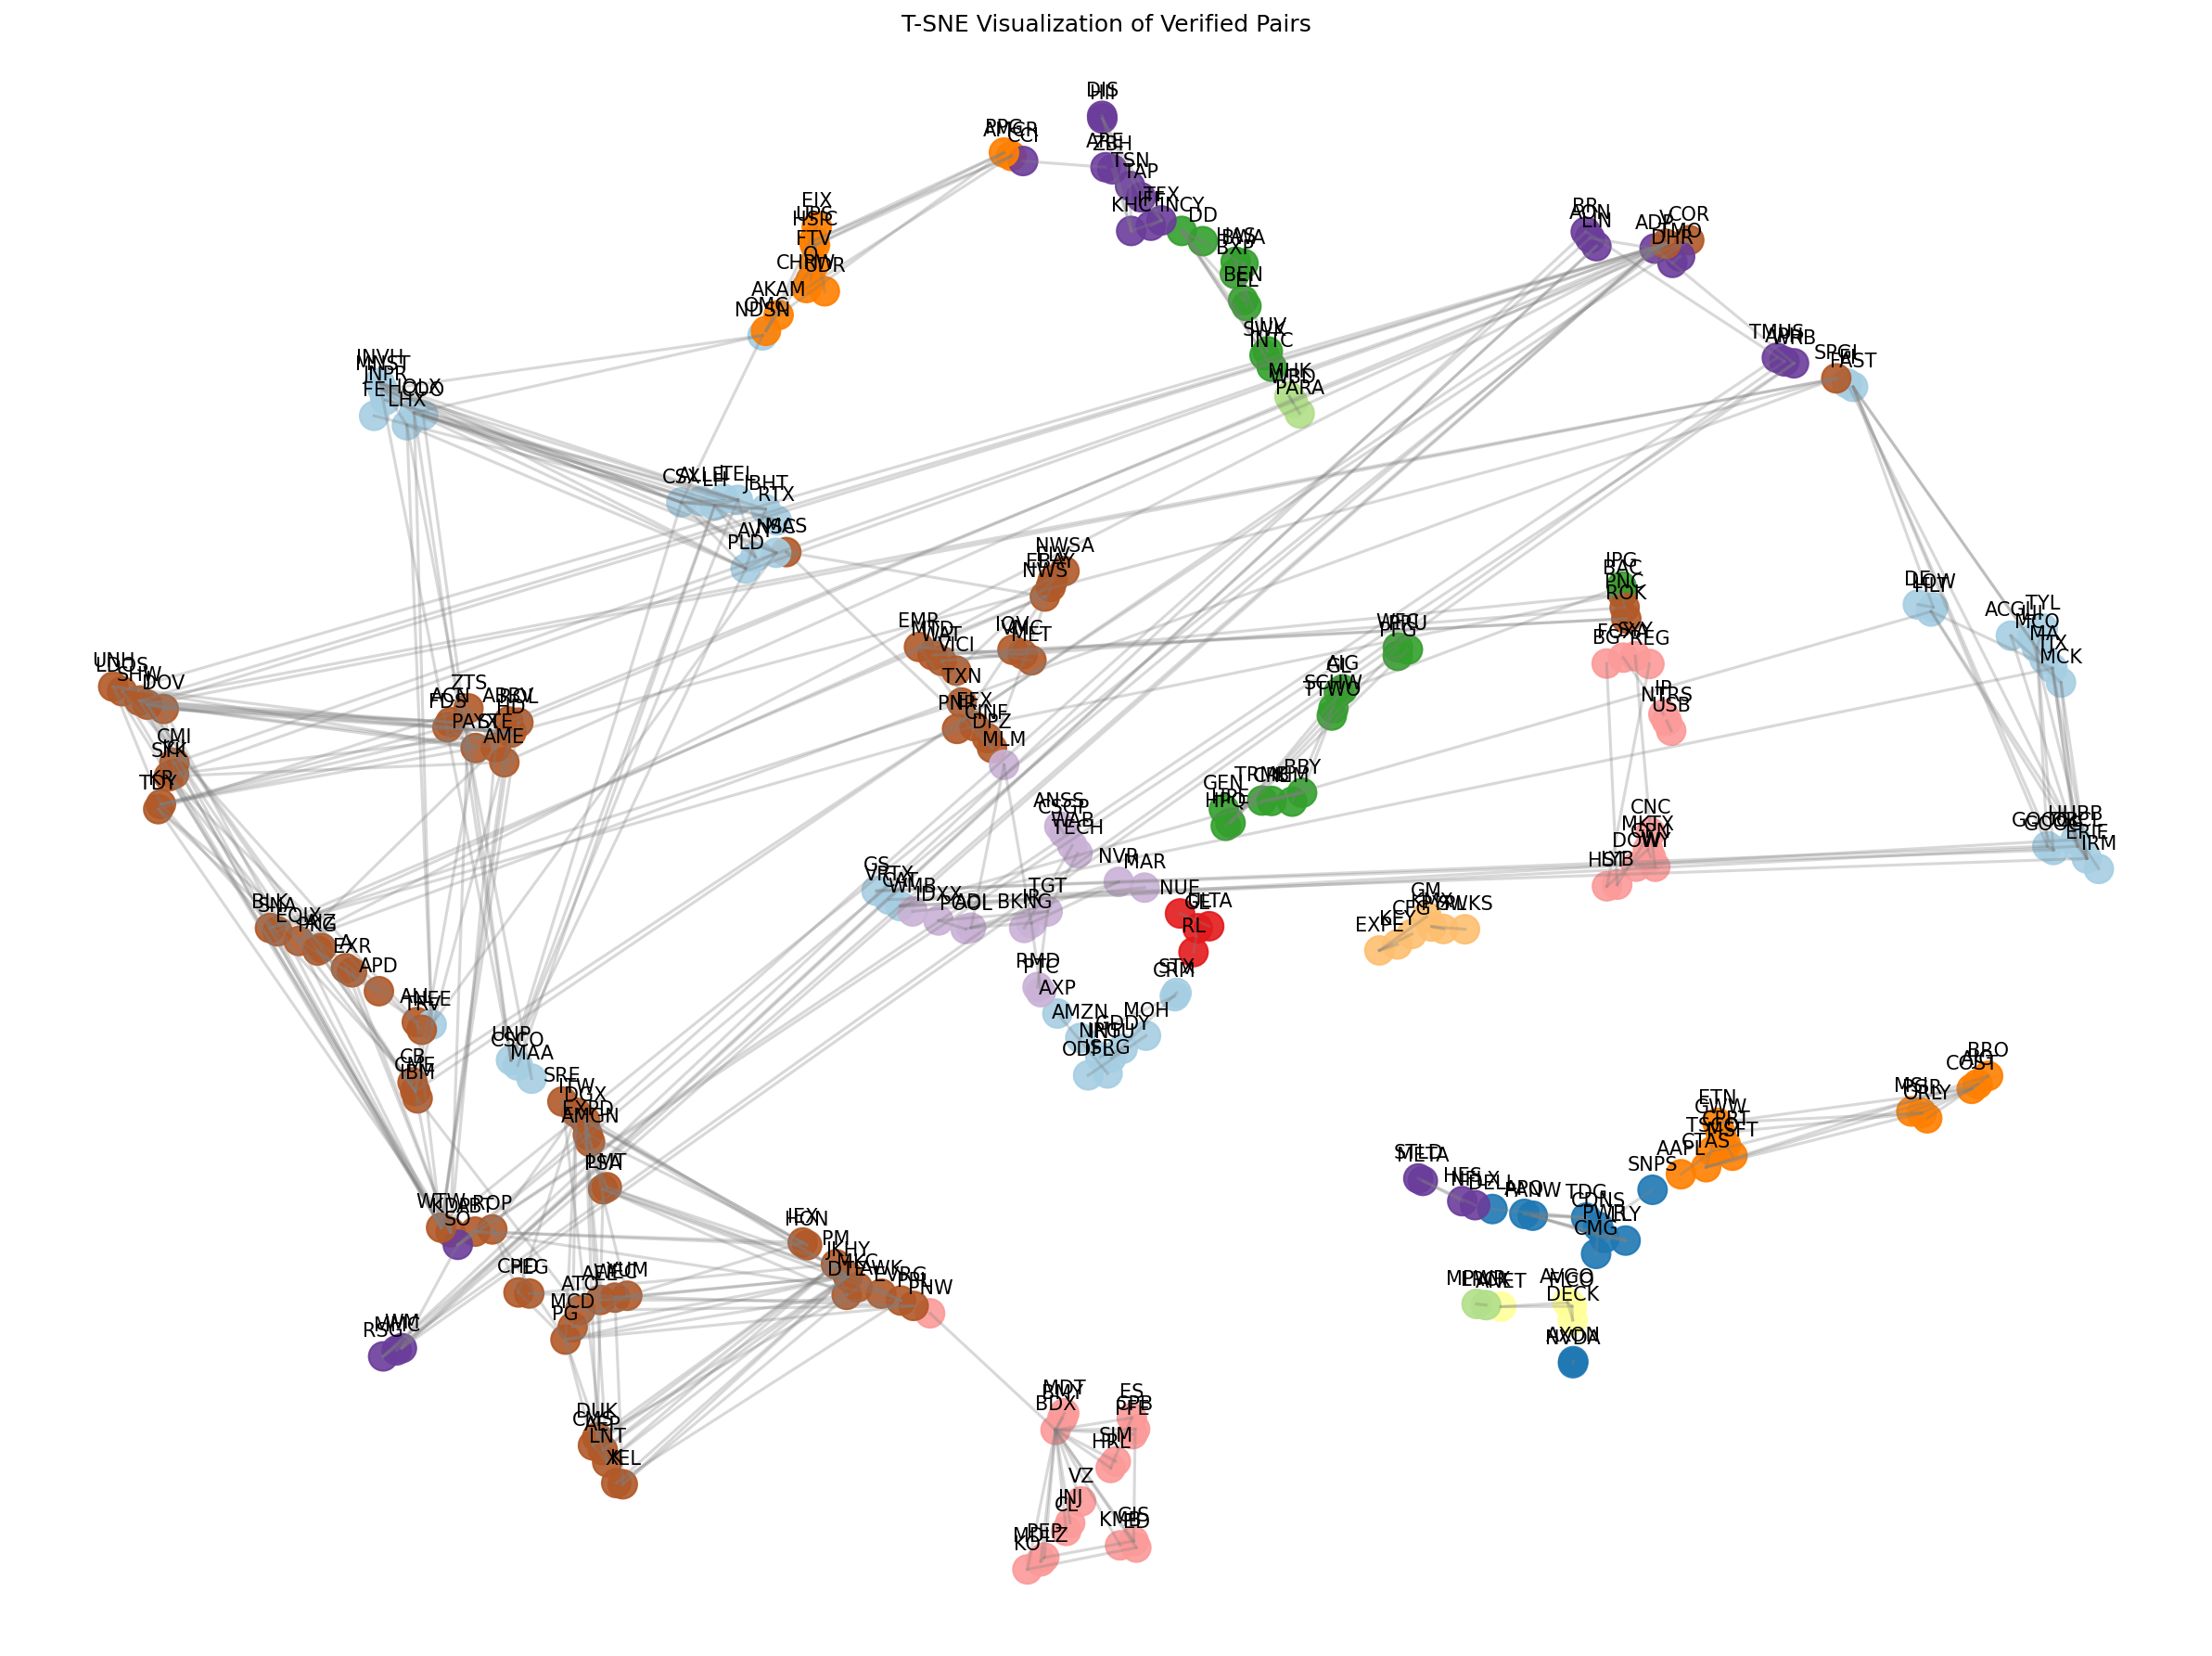

In [34]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white', figsize=(16, 12), dpi=150)
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]

    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray')

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Verified Pairs')

# zip 將 x 和 y 座標成對連接
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], X_pairs.index):
    label = name
    plt.annotate(label,  # 這是文字
                 (x, y),  # 這是要標記的點
                 textcoords="offset points",  # 如何定位文字
                 xytext=(0, 10),  # 文字到點 (x,y) 的距離
                 ha='center')  # 水平對齊可以是左、右或中心

plt.tight_layout()
plt.show()

## 9. NVDA 專項分析
---
### 9.1 分析目標

為達作業目標，特別針對 NVDA 股票進行深入分析：

- 在不同聚類方法中的分組情況

- 潛在配對夥伴的發現

- 風險收益特性分析

### 9.2 聚類歸屬分析

**比較重點：**

- NVDA 在不同方法中的聚類歸屬

- 各聚類的規模和特性

- 配對機會的差異

In [35]:
print("\n" + "=" * 80)
print("Homework 4: NVDA Pairs Analysis Using Different Clustering Methods")
print("=" * 80)

# 首先，讓我們看看 NVDA 在每種方法中屬於哪個聚類
print("\n1. NVDA Cluster Assignment:")
print("-" * 40)

# 檢查 NVDA 是否存在於我們的數據集中
if 'NVDA' in X.index:
    nvda_idx = X.index.get_loc('NVDA')

    # NVDA 的 K-means 聚類
    nvda_kmeans_cluster = k_means.labels_[nvda_idx]
    print(f"NVDA K-means cluster: {nvda_kmeans_cluster}")

    # NVDA 的階層聚類
    nvda_hc_cluster = clust_labels1[nvda_idx]
    print(f"NVDA Hierarchical cluster: {nvda_hc_cluster}")

    # NVDA 的親和力傳播聚類
    nvda_ap_cluster = clust_labels2[nvda_idx]
    print(f"NVDA Affinity Propagation cluster: {nvda_ap_cluster}")

else:
    print("NVDA not found in dataset")


Homework 4: NVDA Pairs Analysis Using Different Clustering Methods

1. NVDA Cluster Assignment:
----------------------------------------
NVDA K-means cluster: 1
NVDA Hierarchical cluster: 0
NVDA Affinity Propagation cluster: 3


### 9.3 配對發現策略

對每種聚類方法：

1. 識別 NVDA 所屬聚類

2. 在該聚類內尋找共整合配對

3. 篩選包含 NVDA 的配對

4. 比較不同方法的結果

In [36]:
# =============================================================================
# K-MEANS 聚類配對分析
# =============================================================================

print("\n2. K-MEANS Clustering Analysis:")
print("-" * 40)

# 使用 K-means 聚類結果尋找配對
def find_pairs_in_cluster(cluster_labels, cluster_num, method_name):
    """在特定聚類內尋找共整合配對"""
    # 獲取與 NVDA 在同一聚類中的股票
    cluster_stocks = X.index[cluster_labels == cluster_num].tolist()

    print(f"\n{method_name} - Cluster {cluster_num} contains {len(cluster_stocks)} stocks:")
    print(cluster_stocks[:10] if len(cluster_stocks) > 10 else cluster_stocks)  # 顯示前 10 個或全部（如果少於 10 個）

    if len(cluster_stocks) > 1:
        # 在此聚類內尋找共整合配對
        cluster_data = dataset[cluster_stocks]
        
        # 根據聚類大小選擇方法
        if len(cluster_stocks) > 20:
            # 大聚類使用快速取樣方法
            print(f"Large cluster detected, using fast sampling method...")
            score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs_fast(
                cluster_data, 
                significance=0.05, 
                sample_size=min(500, len(cluster_stocks) * 5),
                verbose=True
            )
        else:
            # 小聚類使用完整分析
            print(f"Small cluster, using complete analysis...")
            score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
                cluster_data, 
                significance=0.05,
                max_pairs=20,
                verbose=True
            )

        # 篩選包含 NVDA 的配對
        nvda_pairs = [pair for pair in pairs if 'NVDA' in pair]

        print(f"\nCointegrated pairs found in cluster: {len(pairs)}")
        print(f"Pairs containing NVDA: {len(nvda_pairs)}")

        if nvda_pairs:
            print("NVDA pairs:")
            for pair in nvda_pairs:
                print(f"  {pair}")
        else:
            print("No NVDA pairs found in this cluster")

        return pairs, nvda_pairs
    else:
        print("Cluster too small for pair analysis")
        return [], []

# 分析 K-means 聚類
if 'NVDA' in X.index:
    kmeans_pairs, kmeans_nvda_pairs = find_pairs_in_cluster(
        k_means.labels_, nvda_kmeans_cluster, "K-MEANS"
    )

# =============================================================================
# 階層聚類配對分析
# =============================================================================

print("\n3. Hierarchical Clustering Analysis:")
print("-" * 40)

# 分析階層聚類
if 'NVDA' in X.index:
    hc_pairs, hc_nvda_pairs = find_pairs_in_cluster(
        clust_labels1, nvda_hc_cluster, "HIERARCHICAL"
    )

# =============================================================================
# 三種方法的比較
# =============================================================================

print("\n4. Clustering Methods Comparison:")
print("-" * 40)

# Get Affinity Propagation pairs for comparison
if 'NVDA' in X.index:
    ap_cluster_stocks = X.index[clust_labels2 == nvda_ap_cluster].tolist()
    if len(ap_cluster_stocks) > 1:
        ap_cluster_data = dataset[ap_cluster_stocks]
        print(f"\nAFFINITY PROPAGATION - Cluster {nvda_ap_cluster} contains {len(ap_cluster_stocks)} stocks:")
        print(ap_cluster_stocks[:10] if len(ap_cluster_stocks) > 10 else ap_cluster_stocks)
        
        # 根據聚類大小選擇方法
        if len(ap_cluster_stocks) > 20:
            print(f"Large cluster detected, using fast sampling method...")
            ap_score_matrix, ap_pvalue_matrix, ap_pairs = find_cointegrated_pairs_fast(
                ap_cluster_data, 
                significance=0.05, 
                sample_size=min(500, len(ap_cluster_stocks) * 5),
                verbose=True
            )
        else:
            print(f"Small cluster, using complete analysis...")
            ap_score_matrix, ap_pvalue_matrix, ap_pairs = find_cointegrated_pairs(
                ap_cluster_data, 
                significance=0.05,
                max_pairs=20,
                verbose=True
            )
        
        ap_nvda_pairs = [pair for pair in ap_pairs if 'NVDA' in pair]
        print(f"\nCointegrated pairs found in AP cluster: {len(ap_pairs)}")
        print(f"Pairs containing NVDA: {len(ap_nvda_pairs)}")
        if ap_nvda_pairs:
            print("NVDA pairs:")
            for pair in ap_nvda_pairs:
                print(f"  {pair}")
    else:
        ap_pairs, ap_nvda_pairs = [], []

    print(f"\nNVDA Pairs Discovery Summary:")
    print(f"K-means: {len(kmeans_nvda_pairs) if 'kmeans_nvda_pairs' in locals() else 0} pairs")
    print(f"Hierarchical: {len(hc_nvda_pairs) if 'hc_nvda_pairs' in locals() else 0} pairs")
    print(f"Affinity Propagation: {len(ap_nvda_pairs) if 'ap_nvda_pairs' in locals() else 0} pairs")

    # 收集所有獨特的 NVDA 配對
    all_nvda_pairs = set()
    if 'kmeans_nvda_pairs' in locals():
        all_nvda_pairs.update(kmeans_nvda_pairs)
    if 'hc_nvda_pairs' in locals():
        all_nvda_pairs.update(hc_nvda_pairs)
    if 'ap_nvda_pairs' in locals():
        all_nvda_pairs.update(ap_nvda_pairs)

    print(f"\nTotal unique NVDA pairs found across all methods: {len(all_nvda_pairs)}")
    print("=" * 60)
    if all_nvda_pairs:
        for i, pair in enumerate(sorted(all_nvda_pairs), 1):
            print(f"{i:2d}. {pair[0]} - {pair[1]}")
    else:
        print("No NVDA pairs found across all methods.")
    print("=" * 60)


2. K-MEANS Clustering Analysis:
----------------------------------------

K-MEANS - Cluster 1 contains 21 stocks:
['AMD', 'ANET', 'AXON', 'AVGO', 'BLDR', 'CRWD', 'DECK', 'DXCM', 'ENPH', 'FICO']
Large cluster detected, using fast sampling method...
Randomly sampling 105 pairs out of 210 total combinations
Testing 105 pairs for cointegration...
Progress: 95.2% (100/105) - Found 6 pairs (Elapsed: 5.8s)
Completed in 6.0 seconds. Found 6 cointegrated pairs.

Cointegrated pairs found in cluster: 6
Pairs containing NVDA: 1
NVDA pairs:
  ('AXON', 'NVDA')

3. Hierarchical Clustering Analysis:
----------------------------------------

HIERARCHICAL - Cluster 0 contains 70 stocks:
['AMD', 'AMZN', 'AXP', 'AMP', 'APO', 'AMAT', 'ANET', 'ADSK', 'AXON', 'BX']
Large cluster detected, using fast sampling method...
Randomly sampling 350 pairs out of 2415 total combinations
Testing 350 pairs for cointegration...
Progress: 28.6% (100/350) - Found 1 pairs (Elapsed: 5.7s)
Progress: 57.1% (200/350) - Found 6 

### 9.4 特性分析

**分析維度：**

- 年化報酬率水準

- 波動率特性

- 與同聚類股票的比較

- 風險調整後表現

In [37]:
# =============================================================================
# NVDA 特性詳細分析
# =============================================================================

print("\n5. NVDA Characteristics Analysis:")
print("-" * 40)

if 'NVDA' in X.index:
    nvda_returns = returns.loc['NVDA', 'Returns']
    nvda_volatility = returns.loc['NVDA', 'Volatility']

    print(f"NVDA annualized returns: {nvda_returns:.4f}")
    print(f"NVDA volatility: {nvda_volatility:.4f}")

    # 與聚類成員比較
    methods = [
        ('K-means', k_means.labels_, nvda_kmeans_cluster),
        ('Hierarchical', clust_labels1, nvda_hc_cluster),
        ('Affinity Propagation', clust_labels2, nvda_ap_cluster)
    ]

    for method_name, labels, cluster_num in methods:
        cluster_stocks = X.index[labels == cluster_num].tolist()
        if len(cluster_stocks) > 1:
            cluster_returns = returns.loc[cluster_stocks, 'Returns']
            cluster_volatility = returns.loc[cluster_stocks, 'Volatility']

            print(f"\n{method_name} cluster statistics:")
            print(f"  Cluster size: {len(cluster_stocks)}")
            print(f"  Average returns: {cluster_returns.mean():.4f} (NVDA: {nvda_returns:.4f})")
            print(f"  Average volatility: {cluster_volatility.mean():.4f} (NVDA: {nvda_volatility:.4f})")
            print(f"  Returns std: {cluster_returns.std():.4f}")
            print(f"  Volatility std: {cluster_volatility.std():.4f}")


5. NVDA Characteristics Analysis:
----------------------------------------
NVDA annualized returns: 0.6032
NVDA volatility: 0.5156

K-means cluster statistics:
  Cluster size: 21
  Average returns: 0.4643 (NVDA: 0.6032)
  Average volatility: 0.5154 (NVDA: 0.5156)
  Returns std: 0.1092
  Volatility std: 0.1123

Hierarchical cluster statistics:
  Cluster size: 70
  Average returns: 0.3328 (NVDA: 0.6032)
  Average volatility: 0.4213 (NVDA: 0.5156)
  Returns std: 0.1116
  Volatility std: 0.0831

Affinity Propagation cluster statistics:
  Cluster size: 4
  Average returns: 0.5332 (NVDA: 0.6032)
  Average volatility: 0.5348 (NVDA: 0.5156)
  Returns std: 0.0591
  Volatility std: 0.0323


## 10. 視覺化結果
---
### 10.1 聚類視覺化綜合比較圖表

**圖表類型：**

- 散點圖顯示聚類分佈

- 不同顏色代表不同聚類

- 特別標記 NVDA 位置

**4×4 子圖佈局：**
1. K-means 聚類（突出 NVDA）

2. 階層聚類（突出 NVDA）

3. 親和力傳播（突出 NVDA）

4. 聚類規模比較長條圖


6. Creating visualization charts...
----------------------------------------


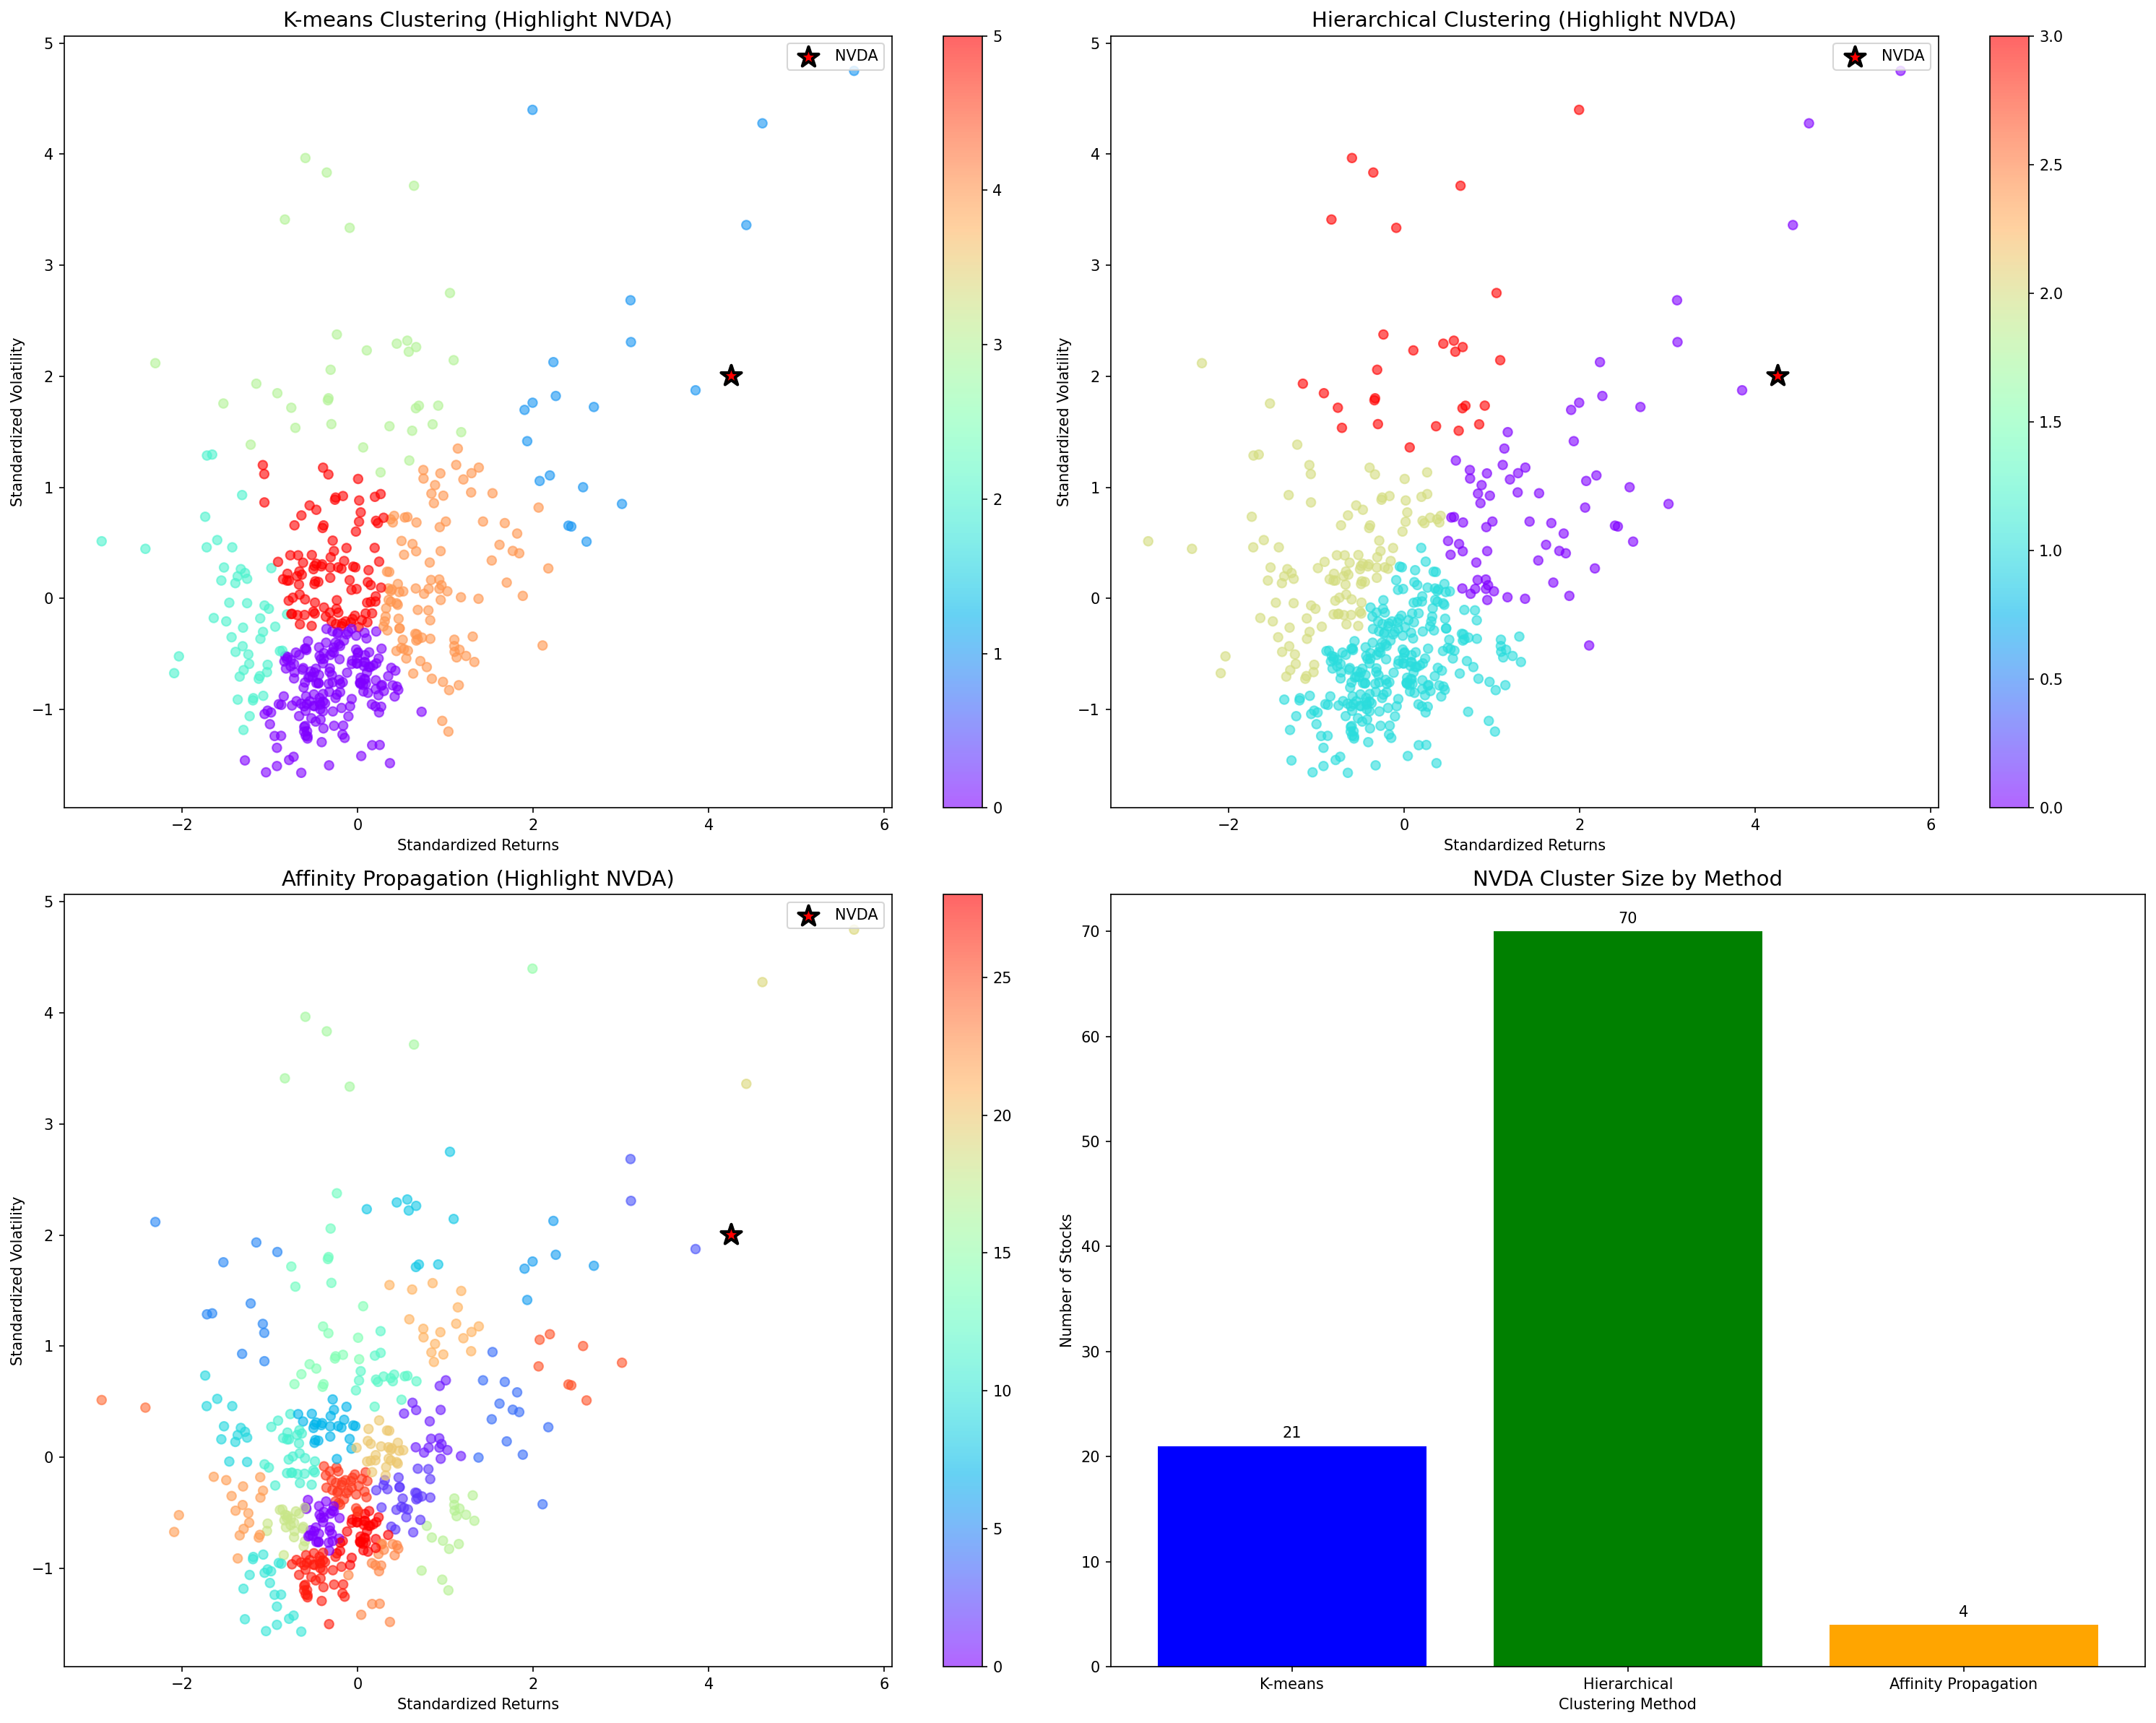

In [39]:
print("\n6. Creating visualization charts...")
print("-" * 40)

# 創建綜合視覺化
fig, axes = plt.subplots(2, 2, figsize=(20, 16), dpi=150)

# 圖 1：突出顯示 NVDA 的 K-means 聚類
ax1 = axes[0, 0]
scatter1 = ax1.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="rainbow", alpha=0.6)
if 'NVDA' in X.index:
    nvda_point = X.loc['NVDA']
    ax1.scatter(nvda_point.iloc[0], nvda_point.iloc[1], c='red', s=200, marker='*',
                edgecolors='black', linewidth=2, label='NVDA')
ax1.set_title('K-means Clustering (Highlight NVDA)', fontsize=14)
ax1.set_xlabel('Standardized Returns')
ax1.set_ylabel('Standardized Volatility')
ax1.legend()
plt.colorbar(scatter1, ax=ax1)

# 圖 2：突出顯示 NVDA 的階層聚類
ax2 = axes[0, 1]
scatter2 = ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels1, cmap="rainbow", alpha=0.6)
if 'NVDA' in X.index:
    ax2.scatter(nvda_point.iloc[0], nvda_point.iloc[1], c='red', s=200, marker='*',
                edgecolors='black', linewidth=2, label='NVDA')
ax2.set_title('Hierarchical Clustering (Highlight NVDA)', fontsize=14)
ax2.set_xlabel('Standardized Returns')
ax2.set_ylabel('Standardized Volatility')
ax2.legend()
plt.colorbar(scatter2, ax=ax2)

# 圖 3：突出顯示 NVDA 的親和力傳播
ax3 = axes[1, 0]
scatter3 = ax3.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels2, cmap="rainbow", alpha=0.6)
if 'NVDA' in X.index:
    ax3.scatter(nvda_point.iloc[0], nvda_point.iloc[1], c='red', s=200, marker='*',
                edgecolors='black', linewidth=2, label='NVDA')
ax3.set_title('Affinity Propagation (Highlight NVDA)', fontsize=14)
ax3.set_xlabel('Standardized Returns')
ax3.set_ylabel('Standardized Volatility')
ax3.legend()
plt.colorbar(scatter3, ax=ax3)

# 圖 4：聚類大小比較
ax4 = axes[1, 1]
methods_data = []
if 'NVDA' in X.index:
    for method_name, labels, cluster_num in methods:
        cluster_size = np.sum(labels == cluster_num)
        methods_data.append((method_name, cluster_size))

if methods_data:
    method_names, cluster_sizes = zip(*methods_data)
    bars = ax4.bar(method_names, cluster_sizes, color=['blue', 'green', 'orange'])
    ax4.set_title('NVDA Cluster Size by Method', fontsize=14)
    ax4.set_ylabel('Number of Stocks')
    ax4.set_xlabel('Clustering Method')

    # 在長條圖上添加數值標籤
    for bar, size in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                 f'{size}', ha='center', va='bottom')

plt.tight_layout()
plt.show()